In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [3]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

## Simulative approach to calculate SIR curves

In [5]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

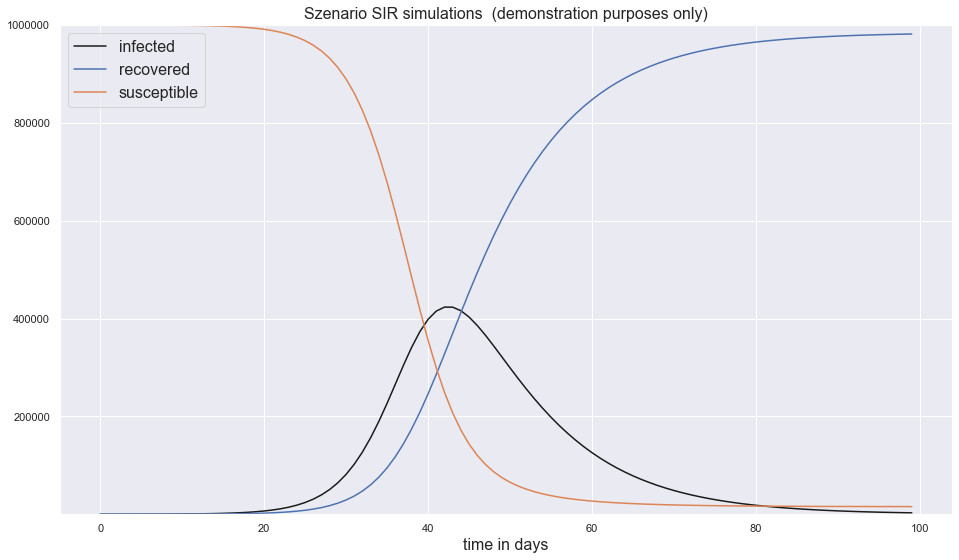

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

## Fitting the parameters of SIR model

In [7]:
ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

In [8]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [9]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [10]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [11]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([2.70000000e+01, 3.64457071e+01, 4.91956207e+01, 6.64053493e+01,
       8.96344660e+01, 1.20987564e+02, 1.63304428e+02, 2.20416326e+02,
       2.97491205e+02, 4.01498275e+02, 5.41832616e+02, 7.31153728e+02,
       9.86509149e+02, 1.33083608e+03, 1.79496099e+03, 2.42024936e+03,
       3.26209305e+03, 4.39445723e+03, 5.91573047e+03, 7.95611026e+03,
       1.06866705e+04, 1.43300301e+04, 1.91720581e+04, 2.55731545e+04,
       3.39761277e+04, 4.49053964e+04, 5.89492486e+04, 7.67139399e+04,
       9.87375269e+04, 1.25356226e+05, 1.56531317e+05, 1.91671801e+05,
       2.29519056e+05, 2.68172791e+05, 3.05306626e+05, 3.38543581e+05,
       3.65876662e+05, 3.85989183e+05, 3.98379367e+05, 4.03287154e+05,
       4.01494345e+05, 3.94088591e+05, 3.82258097e+05, 3.67146745e+05,
       3.49770632e+05, 3.30982618e+05, 3.11468385e+05, 2.91760020e+05,
       2.72257377e+05, 2.53251232e+05, 2.34945074e+05, 2.17474127e+05,
       2.00921199e+05, 1.85329524e+05, 1.70712933e+05, 1.57063815e+05,
      

In [12]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

In [13]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

standard deviation errors :  [0.00530367 0.0049288 ]  start infect: 27
Optimal parameters: beta = 0.2817997301089285  and gamma =  0.11708002495038107


C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [14]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

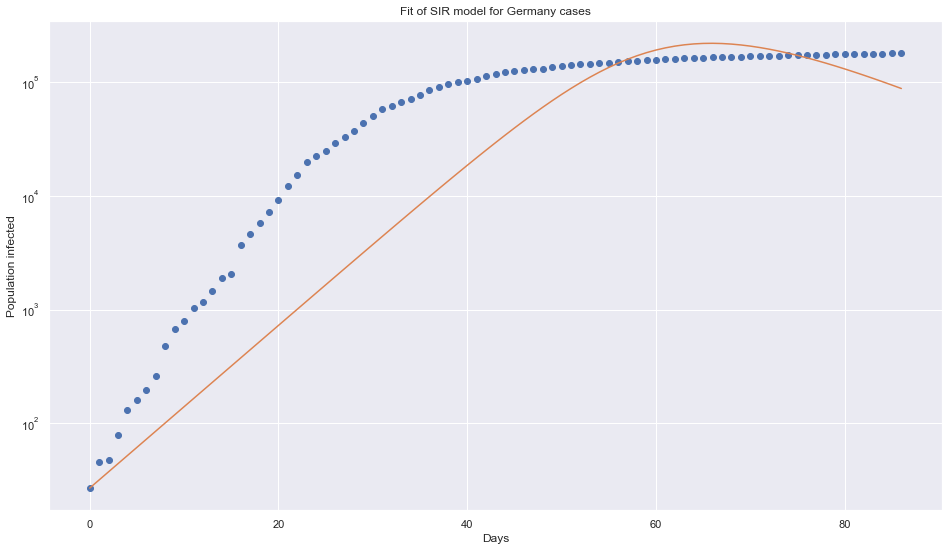

Optimal parameters: beta = 0.2817997301089285  and gamma =  0.11708002495038107
Basic Reproduction Number R0  2.406898445984755
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [15]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

## Dynamic beta in SIR (infection rate)

In [16]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [17]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [18]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

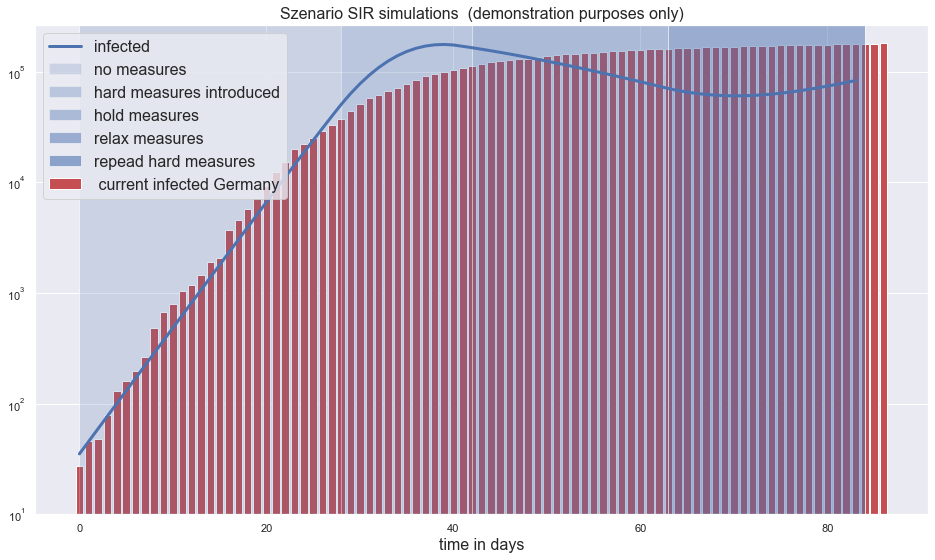

In [19]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA6cAAAIwCAYAAAB6CB0/AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nOzdd3hTVR/A8W922qQTWvYstEBpoawKKgioIKCijNcXWcpGHEUBUREVEVBkb8oGGb4iCgiCKC6WbEQcoGxZ3SNt1n3/CA2EtrRAoaX8Ps/Tp83Jueee3HuT5nfPUimKoiCEEEIIIYQQQhQidWFXQAghhBBCCCGEkOBUCCGEEEIIIUShk+BUCCGEEEIIIUShk+BUCCGEEEIIIUShk+BUCCGEEEIIIUShk+BUCCFEkScTyxd9BXmO5HwLIcS9SYJTIcRtt337dnr16kXDhg2JiIigdevWTJw4kdTU1MKuWr7t3LmTsLAwDh06dEvlWK1W5syZQ7t27YiMjKRBgwZ069aNr7/++rr7O336NGFhYdl+IiMjeeSRRxg/fjw2m+2m67V69WrCwsKIj4+/pdeXl27dutGvX78b2mbVqlVMmjTJ/fj111+nXbt2BV21ApOenk6rVq04fvx4rnlu5jgUZdOmTeOTTz655XKsVivvv/8+W7Zscae1aNGC995775bLFoUn6/Nr48aN+cr/7bff0qNHj9tcKyFEUaQt7AoIIYq377//nv79+/P000/TtWtXjEYjR44cYfbs2ezcuZNly5ah0WgKu5p5Cg8PZ+XKlYSEhNxSOcOGDWP79u3079+fsLAwLBYLmzdv5qWXXmLkyJF06dLlutsPHjyY6Oho9+OkpCQ2bdrE3LlzcTgcDBs27Kbq9dBDD7Fy5Up8fX1vavvbadasWTz00EPuxwMHDiQ9Pb3wKpSHCRMm8MADD1C5cuXCrsodM3XqVIYOHXrL5Vy4cIElS5bQoEEDd9q0adOK5HUpbp8WLVqwYMECVq1aRefOnQu7OkKIO0iCUyHEbRUbG8v999/P6NGj3WmNGzematWq9OvXj59++olmzZoVYg3zx2w2U7du3Vsq4/Tp03z11VdMnDiRNm3auNNbtGhBWloaU6dOzTM4rVSpUrZ6NGvWjL///ps1a9bcdHAaGBhIYGDgTW17p1WsWLGwq5CrU6dOsWLFCjZv3lzYVSk2atWqVdhVEIWgd+/eDB8+nPbt26PX6wu7OkKIO0S69Qohbqv4+Pgcx4/df//9xMTEUKpUKcDVzTGnbqthYWHubeLi4hg6dCiNGjUiKiqK/v37c+rUKffzU6dO5emnn2bdunW0atWKiIgIOnTowN69ez32/eWXX9KhQwfq1KlDnTp1eOaZZ/jll1/cz7/++usMHDiQV199lXr16hETE5Njt97NmzfToUMH6tatS7NmzZg0adJ1u9ZmdZl1Op3Znuvduze9e/e+6a65JpMpzzyxsbE88sgjRERE8PDDDzN9+nR3Xa7t1tuiRQvmzJnDW2+9Rf369YmOjmbKlCmkpKTw2muvERUVRfPmzVm9erW7/Jy6237zzTeEhYVx+vTpHOt04cIFhg8fzgMPPEB4eDgPPPAAo0ePxmq1uutx5swZli1b5r4Wrt1PWloa48aNo0WLFkRGRtKxY0d++ukn9/NZ52737t0888wzRERE0LJlSz799NN8H5/8WrRoEZGRkZQpU8ajfm+99RaNGjUiOjqaOXPmZNvObrczefJkHnroISIiInj66afZvn17ttewY8cOOnXqRGRkJO3atWP37t3s3r2b9u3bU6dOHbp06cKJEyfc29lsNubMmeN+Pzz++OOsXbvW/XxWd8tvv/2WXr16UadOHR588EFmzpzpUb/PP/+ctm3bEhERQdOmTfnggw/IzMwEcJ+XDz/8kBYtWgCu9/OIESPo1asX9erVY9y4cQAcPHiQPn360KBBA2rXrk2rVq1YsWKFuy4tW7YE4OWXX6Zbt25A9m69p0+f5uWXX6ZJkyZERUUxYMAAjy7U+f0cuFrWcdiwYQNdu3YlMjKSNm3a8NVXX2U7B9d27W/QoAFTp04FXO+j6OhoYmNjiY6OplWrVlgsFsLCwlixYgUDBgygTp06tGjRgqVLl3qUk9d1nNd5AFeX8lGjRtGkSRMiIyPp1q0bv/32m0cZN3qdK4rCqlWrePzxx4mMjOTRRx9l4cKFHnnCwsJYvXo1MTExREVFER0dzejRo7Hb7dnKS0hIoHbt2sybN88jfe/evYSFhfHHH38Arv8RDoeDNWvW5Fo3IUTxI8GpEOK2atq0KT/99BP9+/dn/fr1XLx4EQCdTkf//v2pUaMGACNHjmTlypXun8mTJ6PT6XjqqacAyMjIoHv37uzZs4e33nqLDz/8kEuXLtG1a1eSkpLc+zt+/DhTpkxh0KBBTJ06lczMTF5++WX3l6SNGzcydOhQHnroIebMmcOYMWNITk4mJibGHRCBqztyZmYm06dP5z//+U+217Vy5UoGDRpEREQE06ZNo2vXrsyfP5/hw4fneixq1KhBqVKlGDlyJOPGjWPXrl3uL5aRkZH06tULnU533ePpdDqx2+3Y7XZsNhuXLl1i4cKF/PzzzzzxxBO5bvfVV18xefJkevbsybx58+jUqRNTp05l1apVuW4za9YsHA4H06ZN47HHHmP69Ol07NiRoKAgJk+eTNWqVXn77bc5e/bsdet8vdfSu3dvfvvtN0aOHElsbCxPPvkkixcvZuXKlYCrS2dQUBCtWrVyp+VUxurVq+nbty9Tp06lbNmy9O3blx9//NEj7+DBg2nVqhVz5syhVq1avPXWWxw9evSmj8+1FEXhq6++4tFHH822382bNzN06FBGjx7N+vXr2bdvn0eeESNGsGDBArp378706dOpWrUqffr0yRZQDRkyhI4dOzJt2jScTievvPIKb7zxBj179uSDDz7g2LFjHoHcsGHDmDFjBp07d2bmzJlERUXx2muvZQvMhw8fTp06dZg1axbNmzdn0qRJfP/99wDs27ePN954g3bt2jFv3jz69+/PihUrmDZtGoD7vHTr1s2dBq5ArXz58kyZMoXHHnuMs2fP0r17d7y9vZk8eTLTp0+nSpUqjBw5kt9//53g4GD39oMHD2bkyJHZjvG5c+fo1KkTJ06cYOTIkYwZM4bTp0/TpUsXzp8/786X1+dAbkaMGEGNGjWYNm0a4eHhDB48OFuAmJeUlBRWr17N+PHjiYmJwcvLC4Dx48fj7e3N1KlTeeSRRxg1apT7+srPdZzXeVAUhQEDBrB+/XpeeeUVJk+ejF6vp1u3bpw8eRK4uet8woQJvPPOO7Ro0YIZM2bQunVrPvzwQyZOnOiR74MPPiAwMJAZM2bw7LPPsnjx4hzLDQgIoFmzZqxfv94jfe3atdSsWdN9s0Or1dKiRYts+YQQxZwihBC3UWZmpvL6668rNWrUUEJDQ5XQ0FCldevWysSJE5XExMQct8nIyFCefvpp5YknnlAsFouiKIqyfPlypWbNmsrRo0fd+VJSUpQGDRooU6dOVRRFUaZMmaKEhoYqBw4ccOf55ptvlNDQUOXQoUOKoijK7Nmzlffee89jf5s2bVJCQ0OVP/74Q1EURRk2bJgSGhqqxMXFufPs2LFDCQ0NVQ4ePKg4HA7lvvvuU2JiYjzKWb58uRIaGqocOXIk1+Nx5MgRpW3btu5jUbt2baVnz57K+vXrPfJdvT9FUZRTp065t7n254EHHlAmT56sZGZm5rrfd955R2nVqpXidDrdabGxscqWLVsURVGUzz77zOM1N2/eXGndurU7v8ViUWrUqKF069bNvf2JEyeU0NBQZfPmze7j1rZtW4/9bt68WQkNDVVOnTqlKIqidO3aVenbt6+iKIpy9uxZpWvXrtmO1+OPP668+OKL7sfNmzdX3n33Xffjq/ezZcsWJTQ0VPnhhx88yujcubPy1FNPeRzLOXPmuJ9PSkpSwsLClHnz5uXr+OTHn3/+qYSGhio7d+50px05ckQJDQ31OL/nz59Xateu7T4OR48eVUJDQ5VVq1Z5lNe9e3f38c56DbNnz3Y/n3W9ff755+60iRMnKvXr11cURVF+//13JTQ0VFm+fLlHuTExMcp9992n2O1293U1cuRI9/MOh0Np1KiR+30yd+5cJSoqyuP6WrVqlcd+Q0NDldjYWPfjrl27Kg0bNlSsVqs7bevWrUqPHj080hISEpTQ0FBlyZIliqJcuc43bNjgznP1+R8zZoxSt25dj/dmXFycEhUVpYwZM0ZRlPx9Dlwra7+vvPKKR3qHDh2Url27KoqS/T2ZpX79+sqUKVMURbnyPrq6/lnHp1OnTh5pL774otK8eXNFUfJ3Hed1Hn744QclNDRU+fnnn93P22w25dFHH1Vef/11RVFu/DqPj49XwsPDlfHjx3ukjx8/XgkPD3efh9DQUKV3794eedq3b6/069dPUZTs5zXrc+HYsWPuekZHRyvz58/3KGPx4sVK7dq1r/vZJoQoXqTlVAhxW+n1esaMGcN3333HyJEjeeSRR4iLi2PmzJm0a9fOo1tulpEjR3LixAmmTJmC0WgEXF3qKlWqRKVKldwth0ajkfr167Njxw73tlqtltq1a7sfly5dGgCLxQJA3759GTFiBMnJyezfv5/PP/+cL7/8EsCj5fR6YzCPHTtGfHw8rVu39kjP6mq6e/fuXI9HjRo1WLt2LcuXL6d///7UqlWLnTt3EhMTw6uvvpr7gbzstdde43//+x8rV66kS5cuGAwGhg4dyksvvXTdcVlRUVH8888/dOjQgTlz5vDnn3/Sq1cvdzfMnERGRqJSqQAwGo2YTCaPY+vv7w9AcnJynvXOSZkyZViyZAmhoaEcP36crVu3MmvWLOLi4jzOxfX88ssvmEwmHnzwQY/0Nm3acPjwYY8Zoa8eq+vr64u3t7d7YqWbOT7XOnPmjPt1Zclq+WzatKk7LTg42KMuu3btcufJurbtdjvNmjVj7969HsciMjLS/XfJkiUBsp2TlJQU4Mp1eO112qZNG+Lj4zl27FiOx0atVhMcHOw+NnXr1iU9PZ0nnniCyZMnc/DgQTp27Ej79u2vezwqVqzo0ROgWbNmLFy4EKfTye+//87GjRuZO3cuwA2d7+joaI/3ZmBgII0bN3YfR8j7cyA3bdu29XjcokUL9u3bd8Pdu6tVq5Yt7epx5gAtW7bkzJkznDt3Ll/XcV7nYefOnXh5edGwYUP3NQTwwAMPuD8jb/Q6P3DgADabLds11LZtW2w2GwcOHHCn1alTxyNPqVKlcp24rFmzZvj7+7tbRX/88UeSk5OzHf+yZctitVq5dOlSjuUIIYofmRBJCHFHlC5dmi5dutClSxfsdjtffPEFI0eOZNq0ae7xaACLFy9mzZo1TJs2jUqVKrnTExMT+fvvvwkPD89W9tWzour1etTqK/fdsv7O+nJ58eJF3nzzTX744Qd0Oh3Vq1enXLlygOfaiiVKlMj1tWR1I742j9lsxmAw5LlEjkqlol69etSrVw9wjaUdNWoU69ato1OnTtx33325bluhQgUiIiIAV9BgsVgYNmwYgYGB3H///blu98QTT+BwOFi2bBkTJkzg448/pkaNGkyYMCHXGYhzGsea1UWxoHz66adMmjSJS5cuERQURJ06dTAYDPle5zI5OdkdpF0tKy0tLc2dlnWjI4tarXbv52aOz7WygsKr95OcnIxOp8NsNnvkDQoKctctMTER8Axgr5aQkOD+O6dzcu3rypKUlIRWq3XfRMiSdWxSU1Px9vbOsYyrj02DBg2YMWMGCxYsYM6cOcyYMYMKFSowbtw46tevn+O+Ifv7w+FwMHbsWFauXInNZqNixYruWXlv5HzXrFkzx31lddGGvD8HchMUFOTxODAwEJvNdsOzQ+d0Yys4ODjHPImJifm6jvM6D4mJiVgsFo+gPEvWTYIbvc6zPuuurVvWub36s+7az4arr6Gc6tOuXTvWrVvHiy++yNq1a2ncuHG2Y5RVZtZ7SwhR/ElwKoS4bfbv38/AgQOZOXOmx111rVZLhw4d+Pbbbz1ab3bu3Mm4cePo3bs3Dz/8sEdZPj4+1KhRg/fffz/bfm5kJsdXX32V8+fPs3LlSsLDw9FqtXz//fds2rQp32VkfdmPi4vzSE9OTiYzMzNbMJBl7Nix7Nq1y2MSIXB90Rs1ahQbNmzg2LFj1w1Or/XGG2/w/fff8+abb/LVV1+5g42cPPXUUzz11FPExcXx7bffMn36dAYNGsSGDRvyvb/rUalU2b78Xx0cXmvXrl2MGDGCgQMH0rVrV/eX9Y4dO+Z7n35+fjm2qmSNbc7tXOTkVo9P1r5SUlLcQY6/vz82m43k5GSP5VASExPdAYOPjw8qlYrly5ej1Wb/txwQEHDdNVNz4+fnh91uJzEx0eM4ZB2vGzk2LVq0oEWLFqSkpPDDDz8wc+ZM+vXrx7Zt2/L9/ps5cyarVq1i3LhxNGvWDG9vbywWC//73/9u6DXldL4vXbp0Q68nN1k3CrLExcVhMBgwmUzuXgRXB1yKouTZGpvl6psMWWWDK0jN73V8vfPg4+NDiRIlmD179nXrcSPXedZ+L1265J68Luvx1c/fjCeffJKlS5dy6NAhvvvuO959991sebKC44I4t0KIu4N06xVC3DaVK1cmLS2NxYsXZ3vO4XBw6tQpqlevDsDZs2d55ZVXqF+/PjExMdny16tXj9OnT1OuXDkiIiKIiIigdu3aLFy4kK1bt+a7Tvv376dNmzbUqVPHHQhkTTiS39abKlWqEBAQkG1B+ayZPbNaRK9VsWJFDh8+nOMEK1nBR2hoaL7qkMXX15eYmBj+/fdfdxfJnLz55pu89NJLgCsY7tSpEx07duTff/+9of1dj8lkIi4uziNA3bNnT6759+/fj0qlYsCAAe7A9Pz58/z5558e5+LqFrBr1a9fn7S0tGyTH23YsIHw8HAMBkO+6l4QxyerO+/VE/M0atQIwOPmR1JSEvv37/d4DYqikJaW5r62IyIi2L59OwsXLswxYM2PrFbNnK7TEiVK5Hsd1qlTp7rXmvTx8aFt27b06tWLlJQUd8vZ9c5Rlv3791O7dm0ee+wx902Ua997ea15XL9+fXbu3OmeVRpcs2Bv37491/fdjfjuu+88Hm/ZsoVGjRqhUqncrd8XLlzweE15TbKU5drPqS1btlC1alWCg4PzdR3ndR7q169PfHw83t7eHtfR2rVr3UMXbvQ6j4iIQKfT5XgNabVaj27mNyoyMpKQkBDGjh0LkO2GJLjeS3q9PsdWZSFE8SQtp0KI28bf35+YmBjGjBlDYmIiTz31FKVLl+bChQusWLGC8+fPM23aNKxWK4MGDcJutzNgwAAOHz7sEeBUq1aNjh07smTJEp5//nn69u2Lv78/K1euZNOmTdedpfZaERERfP7554SFheHn58fmzZtZvnw54JoROD80Gg2DBg1i1KhR+Pn50bJlS/744w+mTp1K69atcw0wO3TowJo1a3jhhRfo0qULjRs3xmg0cvjwYWJjY2nZsiUNGzbM92u5utwlS5Ywf/58Onfu7DHmMUvDhg0ZNmwYEyZMoEmTJpw7d47ly5fzyCOP3PD+ctO0aVOWLFnCu+++S5s2bdixYwfffPNNrvkjIiJwOp188MEHtG7dmn///ZeZM2ditVo9WqN8fX05fPgwv/zyi7sbaJaHHnqIOnXqMGTIEGJiYihTpgyrV6/mwIEDzJo1K991L4jjExISQnBwMPv27aNx48YAVK1alSeeeMK95EfZsmWZPXu2R0BTs2ZNWrVqxZAhQxg0aBAhISHs2rWLmTNn0rt373wFfjmpUaMGrVq1YuzYsaSlpREWFsaWLVtYv349b7/9dr7LjY6OZvr06bz11lu0bduWpKQkZs2aRf369d03FXx9fdmzZw8NGjTINvYwS0REBHPnzmXp0qWEhoZy6NAhpk+fjkqlcr/3fHx8ANi2bRuVK1d2z+adpWfPnnz++ec8//zzDBw4EEVRmDlzJnq9nh49etzUcbrap59+SmBgIFFRUaxZs4Y//vjDveRLWFgYpUqVYvLkyWi1WlJTU5kyZYq7znn58ccfee+992jRogVbt25l8+bNTJo0CcjfdZzXeWjevDkRERH07duXQYMGUaZMGTZt2sSyZcvcrZI3ep0HBgbSrVs35s2bh0ajoWHDhvzyyy/MmzeP5557Dj8/v1s63u3bt+fjjz+mffv2Ofb62L9/P9HR0XnetBBCFB8SnAohbquePXtSqVIlli5dyvvvv09KSgoBAQHcf//9jB49mgoVKnD69GkOHz7szn+txYsXEx0dzbJly/jwww955513sFqtVK9enRkzZtCsWbN812fMmDG8++67DB8+HIPBQFhYGEuWLKFPnz7s37/f3dKVl65du2I0Gpk/fz6ffvopwcHBPPfccwwcODDXbQwGA4sWLWLevHls3ryZFStW4HA4qFSpEj179szxteeHRqNh6NCh9O7dm/Hjx/Pxxx9ny9O+fXtSU1NZtmwZCxcuxMfHh1atWuVrEqb8atq0KTExMSxdupQ1a9bQuHFjxo4dS58+fXLM37hxY4YPH86iRYv47LPPKF26NI899hharZZFixZhtVrR6/X069ePkSNH0rt3b77++utsrz02Npbx48czceJELBYLNWvWZM6cObmO4cxJQRwflUrFww8/zM8//+xxHYwePZrAwECmTp2KzWajY8eOlCpVyuNmyPjx45k8eTJz5swhLi6OcuXK8eqrr9KrV6987z8nWeUuXLiQxMREqlatykcffXRDN3QaNWrEhAkTmDNnDuvWrcNgMNC0aVNef/11d55BgwYxadIkdu/ezbZt23Isp2/fvly8eJFp06aRmZlJ5cqVGTFiBOvWrXMvrWM2m+nTpw9Lly5l3759Hmuygqt1etmyZXz00UcMGzYMjUZDo0aNmDhxonvSo1vxyiuvsHnzZmJjYwkNDSU2NpaoqCjAda1NmjSJ0aNHM2jQIMqXL8+QIUOyrQmbm969e3PkyBEGDhxIxYoVmThxonuiofxcx3mdB41Gw7x58xg/fjwfffQRqampVKpUiTFjxvD0008DN3edDxkyhICAAFauXElsbCzlypVj6NChBXIzoGnTpnz88cc8+eST2Z6z2WzuyeKEEPcOlZLffmxCCCGEuK6TJ0/y2GOPsX79+nx3mxWF7/Tp07Rs2ZLJkydnm5m2IISFhTF06NBbvtlQ3MydO5dly5bx7bffZmvJ37RpE++99x5btmzJd/d8IcTdT8acCiGEEAWkYsWKdOjQgQULFhR2VYQosr7++ms++ugjpk+fTrdu3XLsYr5w4UIGDBgggakQ9xgJToUQQogCNHToULZt28Y///xT2FURokg6ceIES5cupUWLFnTv3j3b89988w0ajYYuXboUQu2EEIVJuvUKIYQQQgghhCh00nIqhBBCCCGEEKLQSXAqhBBCCCGEEKLQSXAqhBBCCCGEEKLQFbl1ThMS0nA6745hsDqDjn9OJxR2NYS47fx8vUlKTi/satwVfEwGzlxILexqiJvk42MkJSUj74z5UK6UmSP/xBdIWUIUNLPJQGpa5h3bX+2Qkmw7eOaO7U+ILN5eBtItd+5az6/Hm4aQabEVdjXuOLVaRUCAKdfni1xw6nQqd01w6lQUrDZHYVdDiNvO7nDKtZ5PdruTjEx7YVdD3CSD0VFg58/ucJKece998RB3B41Wc0evT7vDSWq6vB/Enaeo1KQVwWtPUbhrYp47Sbr1CiGEEEIIIYQodBKcCiGEEEIIIYQodBKcCiGEEEIIIYQodBKcCiGEEEIIIYQodBKcCiGEEEIIIYQodEVutt68WCxppKYm4nAUhdkwVWgdMoOpKP7SEhLQOp23WIoKUOFEg1PtDaq77uNHCCGEEELcRnfVt0OLJY2UlAT8/YPQ6fSoVKpCrY9KpSLDWhSCZCFuL41GjcNxa8GpoigoTgdWawapqUnYFC9QGwqohkIIIYQQ4m53V3XrTU1NxN8/CL3eUOiBqRDixqhUKtQaLUYvM37+JdEoGYVdJSGEEEIIUYTcVcGpw2FHp9MXdjWEELdIq9WjQnodCCGEEEKIK+6q4BSQFlMhigF5HwshhBBCiGvddcGpEEIIIYQQQojiR4JTAbgmqxFCCCGEEEKIwiLBaSFq2TyaVSuX3tA2M6ZP4ol2LXm8bXN+PXSgQOqxeFEsX6z53y2XM27se/R67r8FUCMhhBBCCCHEvUaC00I0dXosLR9une/8f/99lM/+t5zWj7Vj9AcTCKkWWiD1WLRwLlZrZoGUJYQQQgghhBA3465a57S4qVUr4obypyQnA9CiZStq1Kh1O6okhBDFksOpoALUapmMSwghhCiqJDgtRC2bR9Ov/4t0/k9XFi2cy47tP9GpcxcWLpzLhfPnqVo1hBcGDSa8diSLFs5l8aJYAF4Y8Bx16tRjwqSZOBx2Fi+ax6av15OQkECVKlXp03cQ9eo3dO8nOTmJObOnsX37j9isVmrUDKf/gJepWrUaLZtHAzB71lTWfP4/PlmxBoDdu3eyYN5s/v77KL6+vrR+7HG69+iNRqMBXMv6zJ83m683riMzM4PH2jyJ0+m4w0dQCHGvcTgVUtKtJKVZSU678ttqc2B3KtjtTuyOrB8Fm8OJw+HEeXlYvVajQq/VoNep0es0V/6+/NvXbMCgVeNvNuBv1uNt0Mrs0kIIIYqUAB89WqMhx+fsGZkkpFjvcI0KjgSnRcjp0ydZuGAOPXr2xWQyMXfOdN599w2Wr1hDm7ZP4O8fwJTJHzFk2Ah3y+nH4z/g+61b6PFcXypXrso3mzcy/PVXmDBxJuG1I3E47Ax57UUS4uPo3XsgJUsGs3TpfIYNeYn5C1cwdXosL77Qm6ee6kyrx9oBsHfPLwwfFkPTZs3p8VwfTp08wfx5M0lOTuLlV4YCMH3aRDZuWEuv3gMoV64C//t0OYcO7ad8+YqFdvyEEMWH1e7gXFw6FxItriA01RWIplis3Mr8bXaHgt1hJz2fIxl0WjV+Jr07WHX9dv14GTQSuCUyeWwAACAASURBVAohxF3Ky6BBrc09FHLaXeux55XHkum4blm55dFo1AQF+bgf2zNc/5hyCzqz8iSkWNEaDfz8ZIcc89z/xWcgwWnh2bjzJF/8/A+Z1sJrtTPoNLRrUomHG1S4pXLS09P5aPw0atQMB8DpdDLirSEcO/oXoWE1qVS5CgBVqoRQuXJVTp48ztcb1zP4tTdo2/ZJABo1akx83CXmz5/FxxNmsGP7zxz96w8mTp5FZGQUANWqhzJo4PP88ccRGjRwtZwGlypF9ephAMyfP4tatcIZ8fZod5m+vr58OG4U/3mmK97eJtZ++TnP9+5Ph46uCZDq1W/If5958pZevxDi3pWeYedsXBpnL6VxNi6Ni4mWWwpCr6UCbqY4m93JpaQMLiVlZHtOr1MTYDbg72Pw/G02oNPKlA5CiLvbzQRcN5OvoPJcL5/JZMiWR63VcnLFqlzLqvhMZ4C88+RRVm55LNV7sC9msPvx/V98BpBr0OnOcxcHnvlx1wenX/9yslADU4BMm4Nvdp++5eBUo9EQGlbT/bhkUDAAGRnZvxQBHNi/F4Do6CY4HHZ3eqP7mjBv7gxsNhuHDx/CZDK7A1OAgIBAli1fk2OZGRkZ/PH7bzzfq79HmQ0bNcbpdLJ/3x4CAkvgdDpo1Kix+3m93kB0dBP++P3ITbxyIcS9JiXdyumLqZy5lMa/l9JJSM3/pGwmoxY/swE/kx4/kx5fkx6jXoNWo0arUaPTqNFoVOguP9ZoVGgujzW1OZxYbU6sNgdW+zW/bU6cKrgQl0ZimpXE1EysNmeu9bDanJxPsHA+wZLtObOXjjIlTahV4GfWX66rtLYKIXJW2MFbTnluJuC6mXwFledGyxJF010fnLZqWLFItJw+3KD8LZej0+lRq6/cbc/626nk/OUoOTkJgP90apfj80lJiaSkJOMfEJDvOqSkJON0OomdO4PYuTOyPR8XF4dOpwfAz8/f47nAwBL53o8Q4t6TarFx9HQSf55O5Fx8ep75S/gaKVvCmwBfo0cgqtXcfKukXusaZ4qXLsfn/fy8SEpyBZuKomCxOkhKzSQx1RWsJl71t82ee+CaarHx16nEbOlZ3YT9THp8Lwet/mYDZi+dTNYkxB1QVFv6JHgTwuWuD05bR1ekdXThjHNUqVRkWO15Z7xNTCYzKpWKyVPnos3hg8/Pzx+TyURSYvYvSPv27aZMmbKULl32mjJNAHTt9hxN7m+WbbsSJUryz9/HAEhMTKBkySD3c8lJSbf0eoQQxY8l086xM66A9PTFtFzzqVUqSgV6UbaEibIlTZQp4Y1RX7j/olQqFd4GLd4GLWVKmDyeUxSFtAw7iamZJKRkevxOSst9XGxu3YTVapU7aPU3610tw2Y9vt56CVpFsXanx/0V1ZY+IYTLXR+c3stqR9Rx3dlPT6NBw/vc6cs/WcQ/fx/j9TfeITw8kk9XfcKvhw5QO6IO4GodHT4shkEvDqbd4095tNZ6e5sICanO2TNnCLuqi/GxY38xa+YUnn++H7XCa6PT6fnxh++odnmtVYfDzp49uzAave7QqxdCFFWZNgd/n03mr9OJnDyf4p4p92pqFZQLMlM+yETZEiZKBXrfUovonaZSqTB76TB76SgfZPZ4zuF0kpRqRafXcOCvi+7JnJLSrLm2tjqdCgkprgDXcz/gm8OETD7e0tIqbg+TQYtad51A0HY5WMwjT1qm3aMsrVZTJMb9CSGKNglO72LVqoXyYNPmjPngHbr36E3FSpU5sH8vy5Yu4D/PdEWtVtO4yYNUqx7G+6PeolfvAfj6+bPik8WULFmSh5o/AoDJbObQoQNERNSlZq3a9HyuL2+PGIrJbOaBB5qRlJTEgvmzUKnUVKlaDaPRyH+eeZYVyxej1xuoHhrG2i8+Iz4+nrJlyxXyURFCFJb45Az2/XWJ308m4MgpIgXKB5kILe9PSDk/vAzF81+QRq0m0NdIpXK+OBxXglFFUbBkOi4vgZPpDloTU61YMnPuhaMouPKlWjlxVXpWS6u/WY+/j8EdvJq9dDKm9R6Un4Dy2mARwMdszJZHrdNybMasXMsKGdgfIO8815RVcWAXTq64Mt+FBItCiJwUz28G95A33nyPhQvmsPyTRSQmJhBcqjS9+wyk83+6AqDVavnwoynMmjmF6dMm4nQ6iawTxZBhIzCbXXf7e/Tow4L5szh0cD+ffb6BJvc35b33P2Lp4nls3LAOk8lE/fqN6N33BYxG1z+yns/1Q6838uUX/yM1NYUHH2xO23ZPsm/v7kI7FkKIO09RFP6NS2fPnxf559/kHPOUDvQmtLw/1cr7Yc5lrOe9QKVS4W3U4m3UUrqEt8dzVpuDpFQriZeD1sRUK0mpmaRl5By0erS0/pviTtdqVARcDlYDfFw//j4GDDrNbX1t4uZcL6jMLaDMKU++Aso88mXlEUKIwiTBaSHa8t1O9989evahR88+Hs9Xqxbqkadu3foejwH0ej19+w2ib79Bue7Hz8+fYa+/nevzTz3dmaee7uyR1qTJgzRp8mCu26hUKp7t2pNnu/bMNY8QovhyKgp/n01m758Xc5zcqISvkbCK/lQv74+fSV8INby76HUaggK8CArwHBphszuzT8iUYiU9lyDC7lC4mJjBxUTPMa3eBq1rqZurfvxMMp71dslvS2Z+gkUJKIUQ9xIJToUQQuSb3eHkyIkE9v11kcTU7GutVS7tQ/3QIMqWNEn30gKg06op6e9FSX/PoDXT5nAHqq7frgA205ZzN8n0TDvpmXbOXroyKZVapcLPrCfQx0CA75WgtbAnoipMd7olUwghhKd79z+QEEKIfLM7nOw/eol9f13Ecs04MbVaRY2K/kRVD6KErzGXEkRBMug0lArwplTAle7BWWNas2YOzpo9ODHVijOHMcBO5aquwWevpHsZtO6ANdDHQKCvER/vojuW9VYDyqvzSUumEEIULglOhRBC5EpRFI6eSeLnQ/+SnG7zeE6vUxNRtQR1Q0piuofHkhYVV49pLVvyytI3TqdCSrqVhFSrKxhNziAhJffxrJZMO2cy7Zy5qpU1ayxroK/R/dvffGtrzubHrbZS5iegvDqfEEKIwiXBqRBCiBxdSLTww4GzHl1BAXy8ddStVpLwyoHoZaKdIk+tVl1eN9VA5dI+7nSrzUFCSibxKVe1tKZk5jjTck5jWVUq8DPpCfQ1EuhroISvkQBfA3pt3tdEQbZkCiGEKD4kOBVCCOEhLcPG9sPn+O14gke6Ua/hvlqlCa8SiEYm0rnr6XUaSgV6UyrwStdgp6KQkmYlPiWT+ORMElIyiE/OJMOafSyronB5oiYrf1/VLdjPpKdkgBdB/pd/ArzdywbJmEwhhBDXI8GpEEII4Mq40l9+v4DNfmV9TrUKIkNK0qhm8D09Wc69wDVJkquVtUqZK+mWTDvxyZnEXw5W45MzSLmmm3eWpDTX+q3HTie504yOTHztaVSOqoXZS0OlfLSuCiGEuPfItwwhhLjHKZeXhfnx4L8kp3vOwFu5tA8PRpYhwEcmOirO8upmazLYKelrRK0r4U6z2hxcSrJwKdHCxQTXT3xKBkr2XsFkaAxkaAxc+O3c5ZQzGErUw9eehp8tDV97Kn62NAxKzgGvEEKIe4MEp0IIcQ+zZNr5bt8Zjp5J8kgP9DHwYGRZKl01RlHcnQps6RPIMY/p8k/Lgf1JTErH6oTfPt9IstZEss5EitaEU5V94qRMjYGLGgMXDYHutKwW1oQj5zEbtVS6TsAshBCi+JFPfSGEuEf9828yW/aeJv2qWVuNeg3RtUoRUaUEahlXWqQVxUmFNBo1wX5GUjIuXKkHKtI0XiTpTKiiojkXl0ZCSiZ2R/YmVncL6+HLLax7TuNVIgpfWxp+9lT8bKn42tPQKTmv5yqEEOLuJsGpEELcY6x2Bz8d/Jdf/4n3SA+vHMj9EaVlXGkRkJ/A826ZVEiNgo8jHR9HOiFR5UlJzcDkbeDg3MUk60wka80kXW5ldaqyj0W1aIxYNEbOc6VLsclu4e9dJ/Hz1lGxjC8O1GhwZttWCCHE3aVYfAOxO5xY7Xf+n5JKpcJqd6DXqlEX0cXJhRDiamcvpbFp9ymS066MLfU2aGlZvzxVyvgWYs3E1fLbzfZupVar8HFY8HFYKMclAJxwuYXVjCoqmn8vuVpYc1raJk3rxZ8nXbNJ//L7BVRBDTHbLe7WVX9bKmZH+p18SUIIIQpAsQhOrXYnFxLu/D8hFSoy7Q5KBXpjlLX+hBBFmMPpZMdv59n7x0Wu/qofUs6PFlHl3Et9iNsvP2NA70VqcAesWS2s3t4GDsYuIUlrJklnJlnrGsOqXHNDWFGpSdGZSNGZOO1VCgCN08GhrUfxN+upUNqXDLUeo9OK3EoWQoiiS76NCCFEMXcpycKmX05xKSnDnabXqXmobjnCKvijkp4fd9SdHAN6t9OoVfja0/G1p1Ph8jhWB2qStd7omrfi7MVU4lMySUzJzLatQ63h7KU0zl5Kc63ZW7I+eocVP7urZdXPloqfPVXGrwohRBFS4MHp33//zWuvvUbVqlWpXbs2PXv2LOhdFBstm0czZNgIftm1nZ07tqHT6Xj4kdb0H/ASGo3r1Fgs6SxeFMsP339LfHw8VaqG8Pzz/WjQ8L5cyx38ygBCqlVHp9OzccNabDYrLR9uTb/+LzFv7gw2bfoKg8HAU093psuzPd3bnTlzilkzp7Bv727UajWNmzzAwBdi8PPzd+f5ZvNGVn+2guPH/wYgpFooffq8QGSdqMv1tTB92gR27viZ1NRUKlaqTNeuz/Fg0+YAjBv7Hn/+cYR5C5a7y/zpp+8ZOWIoy5Z/TunSZRn8ygDKl6/A+fPn+O23Q7Rt157+A14mISGe2TOnsGPHz9hsNqLqNeCFQYMpU6YsAA6Hg9i5M9j63WYSEuIpU7YcTz/9Hx5/4umCOWFC3GUUReHgsTh+PPQvzqu6RpYPMvNIg/L4eOsLsXbFj9lLi0avcz/W67X4mK8swXMvt4oWJA1OAuyphFQPomoZH3zMRn6fOZdkrYkknZkkrZlEnZlMjSHbtlaNnouawCszBCsKJoeF47+cxN+kp2JZP5y4WnGFEELceQUenO7Zs4fSpUtjNBqJiooq6OKLnRnTJvLIo4/x3qgPOXhwH0sWz6NChUo88WQHnE4nrw99mZMnT/B8r/4ElyrNhq++ZPjrg/lgzAQaNso9QN24YS2Rderx5ohRHP71IIsWzmXv3l+oVSuCEW+P5ptvNjAvdiZ16tYnPDyC+Pg4Xn6xLyVKlOT14SOx2qwsmDeboUNeYtr0eeh0Or7/fgtjx7xDt+696Nv/RRLi41m8OJZR773JJyu+QKfTMXvWFPbv282gF1/F19ePDRvW8t67bxA7/xMqVaqS7+OyceM62rR9kk6du2D28SUzM4NXYwZitWYy6MVXMRqNfPLJImJe7sfcecvw8fFl1aplbNjwJQMHxhBcqhTbfv6RSRPHUbp02eseKyGKI7vDyXf7znDkRII7TaNWcX/tMtSpVkJaS28DjV7Hb++PcT/WPfsUx1ZudD+WVtHbR6c4KGFLpoQt2Z2Wodbj9XgHTp1PJiHFyrnziTjU13ztUalI03rz++X3yY7fzqMJaoSvLQ1/W8rlVtYUjE5Zf1UIIe6EAg9O69evT8uWLTGbzQwYMIB58+YV9C6KlfDaEbz40msA1KvfkO3bf2Lnzm088WQHduz4mV9/PcjYcZPdwVV0dBMGvdCLebEzrhtwqdUa3h45GoPBSP36jVi39nMUp8LQYSNQq9XUqVuPb7ds5vcjvxIeHsHqz1ZgtVr5cPxUd0tpzZq16d61I999u5lHW7Xh7JnTPNm+Iz169nHvR6fTMfLtYZw+fZIqVUI4eGAf9eo3otlDLQGoHVGHgIBAHI4b6zbl7W1i0IuvotW6LtG1X67m1KmTzFvwCRUrVgYgql4DujzTns9Xr6J7j94cOrCPsNCaPNqqDQB169bHaDRiMGa/ey5EcZZqsbF+xwnOx18Zix/kb6RVw4oE+hqvs6XIzbWtotdyWCV4KWqMTitVy/kR5GfAx2zk6IxZpGm8SLzcupqkM+c4ftWh0pCg9yVBf2WCMKMjk6M7juNv1lOpjB8OVGjIPlGTEEKIW1PgwenBgwdp3Lgxer3eHViI3NWsWdvjcVBQMBaL6wvloYP78Pb2zhaENm/+CDOmTyQ9PQ1vb1OO5VatWg2D4cqXUH//AMqXr4ha7eqspNfr8fLyIjU1FYD9+/ZQKzwCs9mMw+G6sx8cHEylylXYu/cXHm3Vhv926QFAamoKJ08e59TJk2zf9gMANqtr5s/w2pF8tf4L4uPjuO+++7mv8QMMGPjyDR+XsuXKe1w/+/fvoXz5CpQrV95dP6PRSERkXfbt3U33Hr0Jrx3J/HmzGBwzgPvvb0bjJg/yfK+7e0ZLIW7Uv3FprN9xwmPt0pqVAmgeVQ6tRjor3qxrW0WvVeut4XewNuJmqACzw4LZYaE8F4HL41d1JjTNHuHM+RTikjNJtWS/0ZChMXD0dBIAu3+/iCqoEb72NPxtrpZVV+uqNdt2QgghbkyBR49Vq1Zl7NixmM1mOnfuXNDFFztGo2crhkqlQrk8NiwlJYWAgMBs2wQEutLS09NzDU69vL2zpRmMubeYJCcnceTIYR59+P5szwVe3l98fBzjP3yfXbu2o9XqqFy5CqVLlwFw3z8e9OJgSpQoyTebN7B924+o1Wruf6AZQ4a+hclkznX/1/L3D7imfsmcPHk8x/qVK18BgGf+2x2DwciGr75kxvSJzJg+kTp16/HGm+9RsmRQvvctxN3q8D/xfLf/jHt8qUoFD0aUlW68ebi2VdTPz8v9t8NqI9UiXXGLKw1OAmwphIQGU62sLz5mI4dnzbs8btWHRJ2ZZJ0ZxzXrryoqNUk6H5J0PpzA9X/Q4LBydLu0rgohxK3Id3CamprKM888w6xZsyhfvjwAa9euZebMmdjtdnr06MGzzz5LZGQkEydOvG0Vvpf4+PiSkBCfLT0hPg4AX9+CW5PQZDLTKLoxPZ/rl+05by9XoDv6/RFcvHiBqdNiCQ2rgUajZeeOn/nxx63uvAaDkZ7P9aXnc305dfIEP/zwLUsWz2funOm8EjMMlQqciueatFktxdevn4mQkOq8OuTNbM/pdK4vlRqNho6d/kvHTv/l/Plz/PzT9yxaOJfxH41m7LhJN3I4hLirOJwKPx48y8Fjce40o17DY9EVqRDsU4g1uztcr1W01lvDQYLTe4rRacNoTaCU1TUO1Qmkar3RtWzDqfMpxCVnkJSavZU0U6Pn2BlX6+qeP65uXU0hwJaCvy1VWleFECIP+QpODxw4wFtvvcXx48fdaefPn2fixImsXr0avV7PM888Q3R0NNWqVbulCpUokXvr2oULarTa7N3SNHY1mkLoruZ0KGjUatfPTe5fpVJ5bKtSqUAFGo2aOnXqsmrlUvbs2UmjRo3debZu3UJoWE28vLxyKhJU2ct1pZFDmitfRGRdtv38A9WqVUevd83gmZmZyci3X+fBBx+icpUq/Hb4V575b1dqR0S6i9i9eycAahWAQq/nu9D28kRGlatUoXKVXuzd+wsXL5xHo1FjNplJTEhApcLdxfjwoQOuMrKOYw71j4ysy949uyhbthz+/q4xsYqiMHrUCKpUDaF69VBeGzyIKlVDeGFQDGXLlqVT5/9y7Nif/H7kcKFcH8VNQR9DtVpNgH/OLf93M4NO7dHydrulWWx88d1fnDiX4k4LDvCic8tQAu7x8aVOuw21Nvdxonk9n6Ugz+fVs/feSp57YX8FVdat7k8N+NrTCQkpSe2QkgAcmRlLku5K62qi1geH+nqtqy5GRyb+thTSjl6iTAlvTM7rt6wWxeOZX/kpy2QquDkh8lNWfvdXUGXJ/u7u/eXXnd5fUFDeN53zk6eoyldwumrVKkaOHMnQoUPdadu2beO+++5zBwqtWrVi48aNDBo06JYqFBeX6rHkwdWcTid2uzNbusPhxOHInn67qVDhcDpdP46b6zKnKIpH3RVFAcX1mho2akLNmuGMHvW2e7berzes48hvv/L+6PG5v2Yle7muNHJIc+Xr0PG/bPr6K4YOeYmnn/4PWq2WT1d9wm+/HeK55/vhcDgJq1GTjRvWUblKCD5mX376aStrv1wNQHq6BVBRo0Y4ixbGotPpqVCxEkd++5WDB/YTM/h1HA4nDRo15rPPVjJxwjgeav4w+/bu5seftgKu8+twOHOsf6vW7Vj92UpeG/wC/+3SAx9fX9avXcOPP37H+y1b4XA4qR1Rh2VLFxAQEEhYjVqcPHGcrd9toWOnZwrl+ihONBp1gR9Dp9NJQmJagZZZFPiZjSQlWe7Ivi4mWli3/Tgp6VfGyFUr58fDDcqjVpQ7Vo+iys/PK89xoklJljyDz/zkya+U1Iw8v7TnJ8+9sL+CKut27E+v2AmyJhJkTQRcQ1tSNd5oH2nL6XPJXMqldTVDY+CcxsC5/WcA0GrU+PrXcreu+tlS0Sv2bPu706+vIOSnrLS0zAL70p6fsvK7v4IqS/Z3d+8vv+70/i5eTMkz+Lx4MeW6zxcmtVp13cbIfAWno0ePzpZ24cIFgoKujOMLDg7m4MGDN1HFW6fXqgkOyD7G8nZTqVRY7Q70ObTmFgSNRsPYDyczZ/Y05s+bRUaGhZBqoXwwdqJHS2pBKFWqNJOmzGbO7GmM+eAdVCqoHlqDj8ZPo1q1UACGDh3B5Ekf8tG499Hr9VStWo2PJ85g+LAYfvvtEHXq1mPQi6/iZfRi2dIFJCYmEFyqNP0HvESbtk8A0KhRY57vNYAv1nzKpq/XE1WvIcNeH8nwYa9ct34mk5mJk2cxe9ZUJk0ch81mpXLlEN57/yOi73ONQ+3ybE+cTidrv1zNgvmzCQgIpGOnZ+jeo3eBHishioKT51NYt/04dseVm3mNw0vRICz4nhhfer3Zc2WcqLjTVICPI52QqiWoFGzCx2zkyMxYV6uqzodEnQ9JOYxdtTucxOv9iNf7udPM9nT8bSnYjsfj46XFXIAtLkIIUdTd9IRITqfT4wuQoiiF9oVIq1EXyiyUKpXqcnfWm7Plu53Z0ka9/5HHY7PZh8GvDmfwq/mfCXLCpJnZ0ubELs2W9uW6LR6PK1euygdjJuRabtly5Rn30ZRs6es3bHX/7eXlxaCXXmXQS6/mWs6zXXvybNeeHmlXH4uc6g8QFFSKt0a8n2u5Go2GHj37eCx1I0Rx9NfpRL7edQqn4gpM9Vo1rRpVpEqZghuHXtTJOFFR1OkVO8HWRIIvt646UZGi9SZR54O9VhRnL6aSlpH9Ok3VepOq9eb07lMAeBm0+PiFEWBNvrz2ahpqmWhJCFFM3XRwWrp0aXbv3u1+fPHiRYKDgwukUkIIIXL26z9xfLf3jPurqdlLR/sHqhSr9UulVVQUR2oU/Oxp+NnTCImuREpqBiq1mgPL15Cg8yFR50uy1htF5Xmz3ZJpx2II5ILBNXO+WnHiZ0slwJaM5t9kzEYNd+/oMiGE8HTTwWmTJk2YOnUq8fHxeHl5sWnTJkaNGlWQdRNCCHGV3X9cYNuv59yPA3wMtH+gCj7e+kKsVcGTVlFxrzB76ymdGU/pTNfM/A7U7q7AmdXCOXcpDes1c204VWoS9L4k6H35++d/AAj0NWLyqUKA1bXmqpczk+LfuV8IURzddHBaqlQpYmJi6N69OzabjY4dOxIZGZn3hkIIIW6Ioij8/Os59v550Z0W7O/FEw9UwdtQ4MtVCyEKiQYnJWzJlLAlE/LA4ySnWLA5VRz67Ct362q6NnsvifjkDOK9SnPKqzQABkcmAZcnWQqwJbuHAAghRFF3Q99qvv32W4/Hjz/+OI8//niBVkgIIcQVTkXh272n+e14gjutXJCJdo0rY9BprrOlEOJup1KpKOFnpELGBSpkXAAgU60jQedDgs4HS7kQLiZauDb2zMyaFdjoWvpm9xe/UtLfiwqlfFB0PvjZUtHIuFUhbpmiKKRn2IhPtXLcqzRpWm9sKg1lMy4RbE3IuwCRjdxyF0KIIsrucPL1L6c4dibJnVa1jC+toysWyiRwt+p6Y0lBxpMKkR8Gp83dFTik5WPEJ6aTbnVw+KvvL7euZl9z1Wp3cvZSGmcvpUFAbVTucauultUAW9FddkKIokIBrGodqRov18RlGi9+2XoMq83hyuBVyp33uHcZCU5vkgSnQghRBFntDtZvP8GpC6nutJqVAmhZrzzqW5kmvBBdbywpyHhSIW6GTqumvL83memnAXDimvE3XudLos6HBJ0vmRrPcemKSk2i3pdEvS//UA4Uhf2b/6Ckn5FKZfywqnUYnbYc9ibEvUEBUtOtxCdncsKrNKkaL9K0XtjU19xgzQpMrxGcKYHpzZLgVAghipgMq50vfj7O+fh0d1rdaiV5MLLMPbGGqRDi5qkBX3s6vvZ0sJxDAYK6P8c/ZxJJSLVy4q8zpGm9PDdSqYhLyiAuKYM/TiZCyQZ42zMut6q6Wla9HRkyyZIolhQgQ60nVetNmsaLVK0XqRovHD+5Jhy7ukU0J1qNihJ+XmjPHMfsSMdst2B0Wm9/xYspCU6FEKIIybQ5WPPTP1xIsLjTGoeXokFYsASmQogbpgL8zAZCyvnhYzZybOd6rCotCTpf4vWultUUrQnlms+XdK2RdK2RM16uZQINDisBtmTSj12ibEkTyuWyhbibOFERn5zBuYuppFsTOedTjTStEacqf3M4aJwOTA4LZns6ZoeF0NYPoXI6MZuNnDy6/TbX/t4gwakQQhQRNruTL3/2DEwfqluOyJAShVir/JG1SYW4e+gVO6Ws8ZSyupawsavUeD31X47/m0RcUgbnLqbgvGa91UyNnnOakpzbdwYAXckGrjGr1mQC1m/PZAAAIABJREFUbcn42NO4+0bCi+LMptKQpvEiTWMkTetFmsYLi8aIsuPElUw6U67b67VqAnyNaM8cdwekRqfV46aMj7eetLTM2/ci7kESnApxBymKIq1fIkd2h5N1247zb9yVrrwtospRu2rRD0xB1iYV4m6mVZxULO1DgFmHj9nIXzNmk6Q1udZT1fmSoPPBrvb8ymhT67hgCOSCIRBwtSj521IItCXjdSkVb72EquLOcKLCojGQpjES9+cF4hItpFpsWAJq57sMndOGyW7B7LBgtlswOdKp3qk9KpVKWkTvsGIRnNqdChm5DEi+nVSAzeHEoNPc1N3Cls2j6df/RTr/p2tBVy1HixbOZdXKZazfsPWO7K84Gzf2Pf784wjzFizP9zaLF8Xi6+tH+6c6FXh99u/fw6sxA5kxayFhYTULvPwbcTPH5l7ncDr5ascJTl28MvnRg5Fl7prAVAhRvKhRCLCnEmBPBc6iACmXJ1my1ajL2UtpWDI9bzg51BriDP7EGfz5a+sxNGoVpUt4YzSVJ9CajNXuLJTXIooPRVFISbcSp/MlXWN0/1g0xivd0o/nPRGR2VuHr5eOkgHe2PftwmS3oFey30CVxoTCUSyC0wybg6MnE+/4flUq14ya1SsG4CXrDd5TunV7HkuGJe+MV1m0cC79+r94m2ok7lZOp8LGXac4fu7KUg6Nw0sTVT2oEGslhBBXqLgyyVJI48ooisLBOYsuj1t1ta5maAwe2zicCmcupoGpAsdMsPeLExh9q+NjT8dsT8cvNVPWWhU5UoBMtZ50jcEdgP62/TjJaVYcTgV8quSrHLXixNuRgbe7NTQDb7uFqo92JC0tE5PJwMldsoxSUVMsglMh7rSy5coXdhVEMaAoCpv3eK5j2rBGMA1rBBdirbKT8aRCiKupVCrMjgzMjgwqZFwAIF1tIEHvQ7zOj9Sg8iSles5W6lAgTetNmtYbgKPbjvN/9u47vMbzDeD494ycHDmRHSL2FsQKCTFCdRi1R2ntVVtRu/Zo7b2Jvalqaemviqo9YmtrR2pmyU7O+v1x5CVitirG/bkulzzveN77fc8R5z7P0qhVuDvr0WbKRmazLWm1txhloqV3hAk1iRp7rty4R0R0IklGMxFOhUjU2GN9ZMwzsU8f12lvTsZgTiJbkXxkslOT1cORqB++k/fSG0iS0wwWE3OPMaO/4uCBfdjZ2fHBhzXp9HkPtFrbSxMREU7workcOXKQ6OgoXFxcCapanY6duqPT6bh16wafNW9A12692bRxLSkpyYwcNZ5ixUuwft1KNm/eQMy9aCpVroq7+9NbYrZv38r8uTMYNGQkC+bNJCzsOvnyF2DAwGFcD73GwoWzCb97l5KlytCv/1e4utrGmZjNJpYvW8zPO7YRFRVF3rz56NipO2X8yil1Xw+9RnDwPE6eOE58fBzu7p7UrFWHFi3bKd0mdmzfxrq1K7hx42+cnZ0JqlqdDh27otPZP7Hbat2Pq9OocTNat+moxN+seUvWrlmBk7Mz8xesQK/X8+2mdXy3eT137tzG2zsHLVu1p9p7Hyj1HDq4j6VLFnDt2hUyZXKgfPmKfN6lJ05Ozo99Vg93XU19DUaPncT3323k1KkQHDM7Ua9eIz5r0RawdeEGmD9vJt9t3sjqtd/R54su5MiRk9u3b3Hu3Glqf1yfzl16cevWDRbMm8XJU8dJTkqmdGk/Pu/Skxw5cqWJN3jxPEJDr1GgYCFq1673xPhS/f77HoYP7c+qNZvx8vIGYO9vu1i9ainXrl3B1dWNWrXr8+lnrZXX5OjRQyxZPJ/Lly/i5OREjZp1aNW6AxqNRnntgxfPZ8f2rSQnJ1GzVj0sllffxf5NZLVa+fX437ZlG+4rVcCD8kWfPmV9RpDxpEKIZ3GwJOOQlEz2pHDyt/yA2+GxxCSaOL/rMFE6J+LuJ6UPM1ustgngMj34Qk5rMd1v7bL9yRSVgLOjfbpzxZvBaLJwLz6FyLgUwvSeJKntSdLoSNDoH6wZeubWgxMeXeboEXqdBvv46IfeI8k4mBPRWm3dxnMV8L/fKqrj1fepFC+DJKcZbN3aldSt14jRYyYSEnKUVSuXkC1bdho0bIrFYmFg/16oVCp69uqHweDIkSMHWbd2Bd7eOWjQsKlSz9Il8+nTdzBGo5GChYqwft1KFi6Yw2ct2lC0mC87ftrKpo1r0Gof3/qRKjExgelTx9OufRf0ej3Tpo5nyKA+2Ol0tG/fhZiYe8yaOYUlwfPp03cQAJMnjWPP7p20btuJPHny8cv/tjNo4BdMmTqXYsVLkJiYQJ/eXciVOw8DBg5Do9Wya+fPLF2ygPwFChEYWJmzZ08zaeIY2rTtRPHiJbl27Qpz50xHp9PRoWO3536ecXFxbN++lcFDRpGQGI9er2f5skWsXBFM809b4etbikOH9jN2zFDUajVBVatz+9ZNhg8byMd16vN5l57cvXObuXOmk5ySzFdDxzz3tSeOH029+o35pFlLdu/+heDF8yhQsDABAYHMnL2IHt060KBBUz6q+bFyzvbtW6lVux5Nmn6KY2Yn7t69Tbcu7fDw8KRXr/5YsbJieTC9enZi/oIVeHh4cu7cab4a0o8qQdVo37ErZ8+cYtrUCc8dZ6rf9vzKyBGD+KhGbdq178K1a1dYuGAWarWK5p+25vixIwwa0JsqQdVo274T165eJXjxXGJi7tHri/4AzJ41le0//UD7Dl3Inj0nGzes4fTpE2kSaZGe1Wrlt5M3OHs1UtlWPK+brGMqhHhrOOjtyOqRGXWcba3IgA6fsGHlLuK0DsRpHUjM7EZicvovM01qLTFqR2LsHAG4fOQ6ADpnH1u3zPt/9JZkMpmT0VrlC9GMZLFYSVbbkaTWkay2I1mtI1FjryShxl8vPDjYwfu567WzGMlkTlZe77xBFbBTg6uLA6Fr1/8HdyJeF5KcZjA/P3969PwSgNJlyrJ//15OnDhGg4ZNCQ+/S+bMTnTr0Yf8+Qsqxxw5fICTJ4+nSU4/+LCW0hJosVhYu2YFtT+uR5u2nQAoV648nTq04MaNv58aj9FopEPHbkpd58+fYc3q5UydNo8SJUsDcPr0Cf44fxaA0NCr7Ni+jT5fDlZa7/z9KxAZEU5w8DwmT5nD9dBreGfPwdBhY3FxcQWgTJly/P77Hk6dPE5gYGXOnD6BXq+nSdPP0Ol0lCxVBq3WTmlBfl4Wi5k2bTtRzr88AHFxsaxZvZxmzVvRtl1nAMqWK09CQgILF84mqGp1/vjjHEZjCs0/bY27uwcAmTI5cPv2zRe6dtWq7yvPu2SpMvy251cOH9pPQEAgRYv6ApAla1YKFiysnOPgYKB7j77Kfc6dM53k5GQmTJqJs7MLAKVK+dHi0wZsWL+aLl17sW7tSnLkzMlXQ8egUqnw969AfFwcmze/2C/rVSuXULp0WfoPGAZAOf/yREZGcPbsaQCCg+dRtGgxhg4bi0ajpmzZ8jg5OTFh/Gg+adYCBwcDP3y/mXYdOtOocXMAyviVo3mzek+8prA5cPYWJy9FKOUiuVyoVjr7K09Mn9ZdF6TLrhDi5XHQaR6aZAlyfexPeGQ8iUYLVw+GEKt1IE7jgFn9+Dk8UjQ6UjQ6onBKs11jMfPHwavodRpcM+tJ1rmSyZKC3pyMndUk3Tr/BavVilGlIUVtR4raTkk+k9V2/HUklLiEFJJSzFhdiv6j+lVWC3pzCu7eHmTSaXBzzkTi/r1ksiQpLaGpsrg5yJIt7whJTjNY0WK+acpeXtmIi7MNzs6SJStTps3FYrEQFhZK2PVQLl26SFRUJFmyeqU5L3fuB4PDr1+/xr170fj7V1C2qVQqKlepxrq1K58ZUxGfYsrPqV13Cz3UldbJyZm4ONt/LidPHAcgICAQs/nBh1j/8oEsXjgHo9FIocI+TJ+xAJPJxNWrlwkLu87FC39iMpkwGo3Kc0hMTKRThxYEVa1OhQqVqFmrzj/6sP7wszh37gwpKckElK+YNr6ACmz/6Qdu3rxBwUJFsLPT0a1LW6q99wEB5StSIbCy0nX1efkUfTBluVqtxt3Dk6TEp0+a5J09R5oE/PSpEEqV9lMSUwBnZxdKlynHqZO2Z33mzEmqV6+R5tlUrlLthZLT5OQkLl78i67dvkizvdPn3QFISkrizz/O0a59Z8xmE1arGovFQjn/ClgsFk6EHMPVzR2LxZzmfabT2RMQEMiff5x/7ljeNUf+uMPRP+8q5QLZnXnfL2eGtJg+rbsuSJddIcR/K5O9Fg83e6yJtm6dViBFbUe8MhNrJozuXsTEJ2N5wtxJZrWGyBhb0nIjPAEcH/TcUVkt6CxG7C1Gwk7dQKtR4eyoJ8HOGZ0lBZ3FiO4dTGBNZgvxiUbiNJkwqrUYVVpS1FolCf3zcCgJiUaSjGYsT1qOJer5JoVUq2yvs7OjPdawq+jNKUqrd+qaoblqlXwwQZE54Zl1irebJKcZTK/XpymrVCqsD/0G/nHb9wQvnktUVCTu7h4U8SmGvb09Vmva39Iurq7Kz3GxtuT24QQHHiSaz+LgkH5cyKNxpoqJsU3k8kmTjx+7/969aDw8PFm1cinr1q4gPj6OrFmzUayYL1qtVrkPX99SjBozkY0bVrNm9TJWrggmm3d2Bg4cTnHfks8Vd6qH7zPmni2+nt07PPbYyIhwihUvwaTJs1i9ehmbv93A+nWrcHNzp9cX/alUuepzX9den3ZMjFqlwmJ9+kyEqS3JqWJjY8lfoFC641xd3bh69TJge30ffW3d3F5syZGYmJj713/8eyI2NgaLxcKihXNYtHBOuv0RERHY2emA9O+zF43lXfJHaBQHzj4YW5M3W2Y+8s+JWv2ufTQSQoj0VID9/WTSzWj7LJOrTnksFit/bfyeeG2m+0uH2LqNJmp0WFRP/iLZqlKTrLEnWWNPjDIjegxkzpPmOK3FhNZqxs5i4mpIGGqVCoODHYl6T+wsZrRWExqrxfYHM/GJRlKMZvRPypj/YxbAghqzSo1ZpcGk1nAzPJ7Y+GTUUYnc1XtiSt2n0mBUaTGqtZhUWg7+8pdtxlsA5/SfNwCIfrHVCOwsRuwtKdibjegttuQzNQkt0KQ+iQkptsTzr/3/7sbFO0GS09fYyRPHmTJ5HC1atqN+gyZKItO1S9unnpc6iU9UdNq1nlITkpfJYHBEpVIxfebCx3bBdXZ24ecdP7IkeB69vuhPtfc+xNHRNo6kUYMaaY4NDKxMYGBl4uLiOHx4P6tWLGHwoD5s2rwd1f3vNa2WB908rFYrSc9YzsVw/1ojR0/A0zP9DKg5c9q+YS3uW5JxX08hKSmJ48ePsG7tCkaOGMyadVvw8Hh1S3pkdnIiKioy3fbIyAjldXVyciY6Ou0xqV8SpFKpwPJIl5jExAffRhoMBgCiH3mP3L17m7//DqNAAVvX4xYt2xJYMQi1WoXlof+E3d09uHL5klLHw88o9QsBkVbY3Th+ORqmlHN4OlIzIDcatSxUL4QQT6NWq2wTLqWk7dZpBYwqLc4f1iA8OhGj2crt8xfvJ686zOrn+5hrUmsxoSVJY0/s3fgHO54wRjJk72XlZ5Wrr5K4qrCislpRY+X8wWtYrVa0WjUpmfOhtlpRPbR0ju0nFZePhWEym1Gr1SRlznd/nwqLSo3l/t8hey5hMluwWK2YXEvY/pN/1PEH/788dWznCybUGqsZncWIncVkS0AtKdhbjOSsUgG11YqHqwN/b9j4xPPVMo+CeEGSnL7Gzp0/g0qlokXLdkriFx5+lyuXL1G6tN8Tz8uRMxfuHp78/tsuKlUKUrYfPvzyv7Eq7lsSq9VKYkI8ZcuVV7avWb2MK5cvMXDwCM6dO42nZxbq1G2o7P/rrz+Ijo5SWk6XLV3IkcMHmDUnGEdHR95770OMKUYmjB9FfHwcDveTqfCIcKWOc+fOYDY/fSIEH59iaLVaoqMi0zyL7du38vve3QwaPIJt27awZtVSli7fgF6vJzCwMgYHA316dyE8/O5LS07Vz5GEFC9ekh+3beHevWilRfLevWhCjh/l4zr1AdsY1AMHfqdzl55oNLb3xaFDaV9bBwcDUVGRWCwW5bqnT51Isz9vvgIcPLiPRo2bKds3f7uBX37Zzrr1P5A/f0Fu/P03hQv7oNGoMZstXLp0gXlzZ9Cu3ecULVYcOzsde3/bRYH7rb1ms4ljxw6j1z99tr13TWRMEtsOXFNa0t2c7KldITdazX+XmMryL0KIt50K0FlNeLo64KDT2Frnjv6q7DejJkWtJVmtI3NgRaJjkjBZIOLyNaULq1GlfXyy95ysKjUmlZpHf6PGxyQ9KNhlfnIFEfHPPi75odpfQrKnUoFep0UdH4vWasLOYlK6OOssRnJUrQQWC24uDtzc+PjEM5u7gfj4ZDT/4f9j4t0kyelrrEjholgsFmbPmkJQ1ercuX2bVauWYDSmkJSc9MTzVCoVbdp0Ysrkcbi6ueHn58/u3Tv5688/nitBehEFChSicpVqfD1uBK1adyBX7jycPHGcVSuX8EmzFqjVagoX9uGH779l+bJFlCxZhtDQqyxftgiVSkXy/fsoVcqPFcsXM3nSOKpV+4DYuBhWr15Kcd+SuLi4kjmzEx4eniwNno9WoyEhIZ6lSxZgMDg+NT4XF1caNGzKvLkziI2LpUiRoly6eIHgxXMJrFgFg8GREiVKM2vGZEaOGES9eo0wmkysWhFMtmzeStL1MhgcHTl9+iS+vqXSjE99WOMmzfl5xzb6f9mDFi3bYbVaWbVyCVo7rZJEftaiLV06t2HoV/2pV78xly9f5LvNG9LU4x8QyOZv1zNj+kSqVnufkONH2bdvT5pjWrZqx6gRg5kyaRxVqlbnyuVLfLtpHZ937mF7D7XtxLCh/TE4OlKlSjWioqJYEjwPlUpN3nwF0Ov1fNLsM9auWY5OZ0/BQoX5YcsmIiMj8fbO/tKe25suIcnE9/uukmy0fZHioNdSr2Je7O1ebEzzi5LlX4QQ7zoNFjJZUshkSSGXtzPxznpbAnvqwf+HVlC6vprUGlyqBBETlwwqFXdPnbO1qqo0Shdas0qNysERo8mCyWLhGaN3/htWK2psrbVaqxmN1YxjVk9UQCa9HUmXLqKx2LZrrWbsrCbsLLa/8zasQ3KSEUdH/RNnvc16f/IhO60knuLVeyuSU72dhgK5XJ594EumAoxmy3/2IbN0mbJ06foFmzatZftPW/H09CSo6vtotdr7a5qmPPHcWrXrYsXK2tXL+W7zRsr4leOzFm1Ys3r5S49z8JBRLF2ygDWrlxEdHUWWrF506NiVpp+0AOCjGh9z/XooW3/YzLq1K8iaNRtNP2lBaOhVzpw+Cdhmtx3y1WjWrlnOrzt3YKfTERAQSOcuvQDQaDQMGz6O2bOmMGL4QLy8vOn0eQ9WrVzyzPg6fd4DFxc3tm39jmVLFuDm5kHDRs1o1do2DjVnzlyMGTeJpUsWMHKEbXmcUqX8GDxk1AvPFvw0rVt3ZEnwPE6fOsGmzT899pgsWbIybfp8FsyfyTdfj0Sj0VCyVBm+GjYWT0/b+pd58uZjwqQZzJ87gxHDBpIzZy569urH1+OGK/X4+1egXfsubPluAz/v2EbpMuUYMHA4gwY8mAApKKg6w4aPY8WKYH7++UeyZMlK5y49qd+gCQCBFaswasxEVi5fzPbtWzE4GPDz86dDp27KGOQ2bT9Hp9Pz/ZaNxMXFUrlyNWp/XI+Q40df2nN7kxlNFn44cJWYBNu/Va1GRd3APGR20GVsYEIIIQDbZzk7qxk7qxkskCNLZuINOlsSe+jxs/bnqtmU+PhkHBx0XFu3UUlcLaiwqlRYUZH1w/eJT0jB3t6O27/uxnJ/+8PXBStZqlQmOdmIXq/j7u499/dZUd9PQNVWCznq1CY52UhmRz03Nm587AROuWqVeTCp0Onfnni/dloNKSr5clK8vt6K5FSrVuFo/+pvRaVSkZTyz/+B79x1KN220WMmpik3btKcxk2apzuudZuOAHh5eT+2HoDatespy7ukatGy3RPjqVHjY2rUSDuxUaPGzZVlQlJ1696Hbt37KGWdTkenz7srM70+Sq1WP3V/qmrvfaAsYfM4xYqXYM68pWm2PTxh0ePiT71+s+Ytada85RPr9vPzx8/P/6nxPWzAwGHKz096DRYsSjszcoOGTdMs/zNl2tzH1p0nbz7GfTP1qdf39S3FrDnBaba9/0HaMbyftWjDZy3apNn2aJxBVasTVLX6E6+TOg44tVvvo1Qq1WOvI2xjon8+EsrtSNtYXxVQwz83WVzTTzj2oqTLrhBCZDyVSoUaK+rU5PYh7s6Z0GvVGAz2JN9fPudxvD0dlaTS+ITjDJnswGLBTqt+52YWFu+etyI5FUKI183vp29y6caDSciqlPQmn7fTU854ftJlVwghhBBvI+lMLoQQL9mpS+GEXHgweVepAh6ULOCRgREJIYQQQrz+JDkVQoiX6NzVSPacuKGU83s7UalEtgyMSAghhBDizSDdeoUQ4iW5GRHPih1/KivZZXXNxIflcsk6b0IIIYQQz0FaToUQ4iWITUhhzS8XSTHaJo5ycrCjTmAemYpfCCGEEOI5ScupEEL8S2azhQ27LhGXaATA3k5D3Yp5cdA/fkbdJ3naLLwgM/EKIYQQ4u0myakQQvxL2w9fJ+xuPABqFdQqnxs3J/0L1/O0WXhBZuIVQgghxNtN+psJIcS/EHIhnGN/3lXKHwfmJWcWxwyMSAghhBDizSTJqRBC/EM3wuP58cA1pVwsrxtVSnlnYERCCCGEEG8uSU6FEOIfiE8ysn7XJcwW29y8WVwyUScwNyqZmVcIIYQQ4h95K5JTkwXik02v/E9ckokkkwXrP/wwWr1aAOvXrfxX937ixDGqVwvgzz/PP/GY7du3Ur1aAPfuRf+rawkhbCwWK5v2XCYmPgUAvU5D0/fyo7PTZHBkQgghhBBvrrdiQqRko4kj52+/8uuqUGE0mylX1Au9LBchxDvjl2NhXL0Zq5QbVMn7jyZAEkIIIYQQD7wVyakQQrwqZ69EcvDsgy/Dqpb2pmAOl2ee97RlYmSJGCGEEEIISU4zXEzMPcaM/oqDB/ZhZ2fHBx/WpNPnPdBqbS9NYmICy5ct4rc9vxIZGUnefPlp1+5zypYr/8Q6f97xI6tWLeHO7duUKl2G0mXKPTWGEyeO0bd3VyZNmc2iBXO4fPki3t7Z6dW7PyqVilkzJnP9+jUKFipC/wFDyZ49p3Lut5vW8d3m9dy5cxtv7xy0bNWeau99oOyPiAgneNFcjhw5SHR0FC4urgRVrU7HTt3R6XQAHDq4j6VLFnDt2hUyZXKgfPmKfN6lJ05Ozty6dYPPmjdg2IhxBAVVV+rt1KEF+QsUYsDAYUr8X/QewPJli9BoNEybMR8vL29+3bmD1auWERZ2HQ9PTxo1akaDhk2Ves6fO8P8+TO5eOEvtFotpcuUpXPnnmT1yvZiL6R4J9yOSuD7fVeVcqGcLlQu8XzvlactEyNLxAghhBBCSHKa4datXUndeo0YPWYiISFHWbVyCdmyZadBw6ZYLBYG9u9FaOg12rXvTJasXvz04/cMGtiHcV9PoZx/+gR1z+6djP9mJPXqN6ZChcocOLCXxQvnPFcsX48bQatW7cmS1Yu5c6YxZtRX6PV6WrRsj9ZOy4zpE5kxbSLjJ84AYPmyRaxcEUzzT1vh61uKQ4f2M3bMUNRqNUFVqyvxq1Qqevbqh8HgyJEjB1m3dgXe3jlo0LApt2/dZPiwgXxcpz6fd+nJ3Tu3mTtnOskpyXw1dMwLPcuVK4Lp3XcQ8XGxeHl5s2P7NiaMH0W9+o3p3KUn586dYc7saaSkJPNJs5YkJSUxaFBvypYNoHXrjsTGxrBgwSxGj/6KWbMXv9C1xdsvMdnE+l8vYTRZAHB3sqd+5TwyAZIQQgghxEsiyWkG8/Pzp0fPLwEoXaYs+/fv5cSJYzRo2JSDB/dx5swpvhk/XUlEAwIC6d6tPYsXzXlscrp69TLK+VegZ69+AJTzL8+dO7c5sH/vM2Np0LApH9dpAMDtWzeZNnU8AwYO58OPagFw7eplNn+7AYC4uFjWrF5Os+ataNuuMwBly5UnISGBhQtnE1S1OuHhd8mc2YluPfqQP39B5R6PHD7AyZPHadCwKX/8cQ6jMYXmn7bG3d0DgEyZHLh9++YLP8tGjZsRGFgZAIvFwuLFc6n+fg3lWZQtVx6VSsXKFcHUrdeYa9euEBsTQ4OGn1CsmC8Azs4uhIQcxWKxoFbLOGJhY7Va2bz3ClGxyQDYadU0fa8Aep38ChVCCCGEeFnk03cGK3o/KUrl5ZWNuDjbRCunT4Xg4OCQLgmtVu0DLlz4k4SE+DTbk5KSuHTxL/z9K6TZXrlyteeKpUiRosrPrm7uABQqXETZ5uTkTHx8HADnzp0hJSWZgPIVMZtNyh//gArcvPE3N2/eIEuWrEyZNpe8efMTFhbKwQO/s2rlUqKiIjEajQAULFQEOzsd3bq0Zf68GZw4cYwKgZVp1Lj5c8X8sNy58yo/h4WFEhF+l/LlAx+JL5CEhAT++OMsuXLlJrOTE18N7suM6RM5dGg/PkWL06ZtJ0lMRRp7TtzgYtg9pVyvUh48XTJlYERCCCGEEG8f+do/g+n1aWf4VKlUWO+vmxgbG4urq1u6c1zdbNsSEhLSbI+Li8VqteLsnHZyFrf7ieazODgYnhlfqph7tg/qPbt3eOz+yIhwsmXz5sdt3xO8eC5RUZG4u3tQxKcY9vb2WK22e/T2zs6kybNYvXoZm7/dwPp1q3Bzc6fXF/2pVLnqc8WdyuWhZ5Ua39gxwxg7Zthj4ovAwcHAtGnzWbF8MT/v+JEt323E0TEz7Tt0oW69Ri90bfH2uhAWzW8nH7TkBxb3omie9P8uhRBCCCHrgg9DAAAgAElEQVTEvyPJ6Wssc2YnoqIi022PiowAwMnJ6ZHjM6NSqYiOTntOTMw9XjaDoyMAI0dPwNMzS7r9OXPm4uSJ40yZPI4WLdtRv0ETXFxcAejapW2aY4v7lmTc11NISkri+PEjrFu7gpEjBrNm3RZU2MbzpSbsqRITE58rvp69+lHEp1i6/V5e3gDkyZuPocPHYjQaOX3qBN9+u47p0yZQsGBhfIoWf55HId5iUbHJbP7tilLOmy0z75XJnoERCSGEEEK8vaTv4mvM17ckCQkJHDl8MM32Xbt+oVChIuh09mm229vr8SlanN/37kmz/dCh/S89Nh+fYmi1WqKjIilc2Ef5c+XKJVYsX4zVauXc+TOoVCpatGynJKbh4Xe5cvkS3G853bZtCy0+bYDJZEKv1xMYWJl27TpjsZgJD7+Lg8HWmhsRcVe59t27d7h168ZT48uVKzdOTs7cvXsnTXwx9+6xJHg+8fFxHD58gEYNahAdHYWdnR1l/MrRo0dfAO7cefXr5orXi9FkYcOuiySlmAFwcrCjYVA+1GqZAEkIIYQQ4r8gLaevsYDyFfHxKcbX44Yrs/Xu+Gkrf5w/y5ixkx57Tus2HRk04AsmjB9FtWofEhJylH2/737psbm4uNKgYVPmzZ1BbFwsRYoU5dLFCwQvnktgxSoYDI4UKVwUi8XC7FlTCKpanTu3b7Nq1RKMxhSSkpMAKFGiNLNmTGbkiEHUq9cIo8nEqhXBZMvmTYEChdBqtfj4FGP9ulV4emZFo9GwfNkiHB0zPzU+jUZL6zYdmTtnGgBlypTj5q0bLF44h+w5cpItmzeOjo5YrVaGDxtAs+atsNNq2bRpLY6OmSlV2u+lPzPx5rBarfx48Bq3Im0t9Bq1iibV8mPQp1+n1MnBDs39ZZEA7O3UODs/GI8qa5gKIYQQQjyftyI5tbfTUs4nawZcWYXJYsHeTqO0BL5MGo2GbyZMZ8H8WQQvnkdSUiL5CxRi3DdT0016lKps2QBGjPyGJcHz+XXn/yhcxIdOn/dgxvSJLz2+Tp/3wMXFjW1bv2PZkgW4uXnQsFEzWrW2jUMtXaYsXbp+waZNa9n+01Y8PT0Jqvo+Wq2WTRvXkpKSQs6cuRgzbhJLlyxg5IhBAJQq5cfgIaOUtV77DxzGtKnjGTd2OG5u7jT/tBXHjh1+Znz1GzTB3t6ejRvWsHHDapycnAkKqk67Dp1RqVQ4OTnzzfhpLFw4h2/GjcBkMlLEpxgTJ81MN25XvFuO/xXOyYsRSvkj/5xk93R87LEanY6Tffsp5Zwfvc+5Xx70VpA1TIUQQgghns9bkZxq1aC1f/W3olKpSEox/ePEdOeuQ+m2jR6TNol0dMxMn76D6NN30GPrKFXKL109FSsFUbFSUJpt9eo3fmIcj6ujUqWgdNsaNW6eZhZdtVpNs+Ytada85RPrbtykOY2bpJ95t3WbjsrPfn7++Pn5P7GOXLnyMGXq3DTb6tRt+NT4U9WsVZeateo+se5ChX2YOGnmE/eLd8/fd+PYfihUKZfM745fYc8MjEgIIYQQ4t0gY06FEOK+hCQjG3Zfxnx/Ai4vt0zUqpAblUrGmQohhBBC/NckORVCCMBisbJpz2Vi4lMA0Os0NKlWADut/JoUQgghhHgV5FOXEEIAu0/8zZWbsUq5fuW8uGa2f8oZQgghhBDiZXorxpwKIcS/8WdoFL+fuqWUq5TMRqGcLulm4n2UOSXlVYQnhBBCCPFOkORUCPFOi4hJ4ru9V5Vyfm8nqpT0BtLPxPuokpNf/izYQgghhBDvKunWK4R4ZxlNZjbsukSy0QyAs0FHgyr5UKtlAiQhhBBCiFdNklMhxDvJarWy7UAod6ISAdCoVTSplh8HvXQoEUIIIYTICJKcCiHeScf/CufUpQilXLN8Lrw9DBkYkRBCCCHEu02SUyHEO+dGeDzbD4Uq5VIF3Cld0CMDIxJCCCGEENJ/TQjxTklMNrFh1yXMFisA3h4GmtfwQafVKMeYU1KISTBmVIhCCCGEEO+ktyI5NQPJRssrv64KMFtAp1Vjtby66/f5ogv6TJkY9/WUV3ZNId4GVquVzXuvcC/etgSMncVI+dM/cD5kXZrjSk6eCJKcCiGEEEK8Um9FcppstPDzwauv/LoqlQqT2cJH5fNgJx2khXjt7T11k4th95RypcgTOJkSMjAiIYQQQgiRSlIqIcQ74fKNGHaH3FDK7/nlJHfi7QyMSAghhBBCPOytaDl9U1WvFkC79l3Y+ct2IqMi6N1nIEFB1fnrz/MsmD+Lc+dOo9dnotp7H9CxU3f0ev1j64mICCd40VyOHDlIdHQULi6uBFWtTsdO3dHpdKxbu4IF82fx9fhp+PtXAGDN6mUEL57P9JnzKVrUN12d478ZRWJiAkWLFmfTxrXExcXiHxDIl/2GsGnjWrZs2YjFbKF69Y/o2r03arXte46oqEjmz53BwYP7MBqNlC5Tlm7d+5Atm7dS95HDB1m9aikXLvyJyWQiV67ctGzVnspVqgFgNptZtHAOu3f9j6ioSLJ5Z6dhw0+oU7chAMuWLmT9ulVs+2m3UufFi3/xeceWTJ46h1Kl/Bj/zSji4mLR2+s5ePB3/AMCGTpsLImJiSxaOJvdu38hIT4BH59idOn2BQULFlbqWrd2BVt/+I67d+/g4enJRx/V5rMWbZV7FG+emPgUvt1zWSnnzupIrYp5OfNdBgYlhBBCCCHSkOQ0gy1ftpBu3fvg7OyCr28prl69TO8vOlO0qC9Dh48jOiqSRQvncPPmjceOMbVYLAzs3wuVSkXPXv0wGBw5cuQg69auwNs7Bw0aNqVxk0/Zs3sns2ZOZtHi1dy+dZPlyxbzSbPPHpuYpjp29BAREeH0+XIwt27eYNbMyVy6dIHs2XMwYOBwjh09zMYNqylarDjvVf+I5OQk+vbuSkpKMt179EWv17N69TJ69/qchYtXkTmzE3+cP8vgQb35uE4DWrXuQEJCPGvXrmDsmGGsXf89Li6urF+/ip9++p6uXXuTJWtW9u/by7Sp4/Hy8qacf/nnfraHDu6jQmBlRo6agEqtwmq1MnTIl1y+fJH2Hbrg5u7Bls0b6Nu7C/PmL8c7ew52/fo/lgQvoEvXXuTJk4+zZ08RvHgeLi6uSnIs3ixms4UNuy+RkGwCwDGTHY2C8qNRqzI4MiGEEEII8TBJTjOYX9kA6tZrpJTnzJ6Kq6sbY7+egk6nAyB7jpz07tWZUydDKFGydJrzw8PvkjmzE9169CF//oIAlC5TliOHD3Dy5HEaNGyKRqOhb78hdO3chg3rV3P48H6y58hJ6zadnhpbYmIiI0Z+g7u7bYmN//3vJ0KvXWHe/GU4OBjw96/Ant2/cP78Wd6r/hE/7/iR69dDWbxkNbly5VFi+bRZfTZ/u55WrTtw9eplKlWuSq8v+ivXyZLVi86dWnH+/FkqVKjE6ZMhFC7kw4cf1QKgVCk/9Ho99nr7F3q2ZrOZPn0H4ezsAthabENCjjJh0kz8/PwB8PcvT7u2zVm1cgn9Bgzl1KkQvLyyUbdeI1QqFSVLlUGr1eLu4flC1xavj/8dDePvu/EAqFTQKCgfjg52GRyVEEIIIYR4lCSnGSx37rxpyidCjlGxUhAajRqz2dbSU6yYLwaDgePHj6RLTrNkycqUaXOxWCyEhYUSdj2US5cuEhUVSZasXspx+fMXpFnzVixdMh+1Ws2sOcHY2T39A7pnlqxKYgrg6uqGxWLBwcGgbHNyciYuLs4W+4lj5MiRk+zZcyix6/V6fEuUIuT4UVq17kCNmnWoUbMOiYmJhIZeJex6KCEhRwEwpthmUC1WvATBi+fRp3cXKlYMokJgZdq17/xCzxXAxcVVSUxT49Pr9ZQsWUaJD6Bs2QD2799ru3axEny/ZRNdO7ehStB7lK9QiaaftHjha4uM4+Rgh+b+Fzshf97h8Pk7yr46lfLhm89NlokRQgghhHgNSXKawVxdXdOUY2LusfWHzWz9YXO6YyMjwh9bx4/bvid48VyioiJxd/egiE8x7O3tsVqtaY57/4OarFwRTLZs3uTNm/+ZsTlkcki3TW//+HGvtthjCA29yofvV0y3L3uOnICtNXbqlG/Yvet/AOTMmZv8BQoBYMUWb7PmrbC31/PTj98zZ/ZU5syeSslSZRg8ZBQeL9CC6eKS/tkmJSXx0Qfp49Nqbf8U3v+gBmazmS1bNrJ40VwWLZxD/vwFGTJ0dLovEsTrSaPTcbJvP6K1BrZmrQxq22ubK+Emrqu3opFlYoQQQgghXkuSnL5mDAZHAitWSdPVN5Wzs3O6bSdPHGfK5HG0aNmO+g2aKAlZ1y5t0x07c8ZEsufIyd07d1i9aimtWnd4ybEbyJ+/IH37DUm3L7WVdtaMSRw7eohx30ylRInS6HQ6rl69zM5ftivHajQaGjdpTuMmzbl9+xb7ft/DsqULmTRxLN+Mn4ZKpcJqTbuubGLis5cDMRgMuLi6Mu7rqU897qMatfmoRm2ioiI5sP93VixfxIhhA1mybN1TzxOvD6NKw26PspjuJ6aZjfFUijyJjDIVQgghhHh9yfSjr5niviW5HnqNQoWKULiwD4UL++DpmYVFC2Zz5crldMefO38GlUpFi5btlMQ0PPwuVy5fgodaTrf/9APHjx2hX/+v+PSz1qxetZSrV9PX92/4+pbk1q0beHllU2IvVKgImzas4eCB323xnjtDuXLlKVs2QBlTe+TwQVsF98Pt368Hc2ZPAyBrVi8aNvqEipWqcOf2LQAcHAwkJycTFxerXPv0qRPPjK+4bynuRUeTKVMmJb7ChX3Y+ct2fvnfTwBMmjiWEcMHArZuzLVq16VmrbrcuXPr3z8g8UpYrVYOuPoSbZcZAI3FTLWIo+ispmecKYQQQgghMpIkp6+Zli3b8ddf5xk1cjCHDu3n9727GTSwN5cuXaDA/e6vDytSuCgWi4XZs6Zw4sQxft7xI337dMVoTCEpOQmAyMgI5s2dwUcf1cbXtxSfNGtJlqxeTJo4FovFkq7Of6pGzTo4OTnT/8se7N71C8eOHWb0yCHs2vU/ZbKmwoV92L9/Lzu2byMk5ChLguexeNFcAJKSbPH6+pbi+y0bWbd2BSdOHOP7LZvYs/tXKlepCoB/gG05nEkTxhAScpSNG9bw/ZZNz4yvQoVKFC5clMEDeyvXnzF9Ips2rlUmcCpZsjR7f9vFooVzCAk5ys87fuT7LZuoVLnqS3tO4r914MxNLhtyKOXy0adxM8Y+5QwhhBBCCPE6eCu69drbqfmwfJ5Xfl0VYLZY0WnVWF9SkleosA+TJs8mePE8Rg4fiE5nT7HiJRg0aASenlnSHV+6TFm6dP2CTZvWsv2nrXh6ehJU9X20Wi2bNq4lJSWFGdMmgAo6de4BgE6no2fPLxnQvxebv11Ho8bNX0rsBoMjU6fPY/68mUybOh6jMYU8efIzasxEAsrbxnl27tqL5JRk5sy2da3NlTsPI0d9w5w50zh37jQf1ajNp5+1wWKx8MP337IkeD6urm40btJM6YacK1ce+n45hFUrgxk0oDc+PsUYPuJrundr/9T4NBoN4ydOZ8H8WSxYMJOE+ASy58hJvwFDqVHjYwA++LAW8fHxbPluI5s2rsVgMFAl6D06dur2Up6R+G/djIjn290XlXLBuFAKxodlYERCCCGEEOJ5vRXJqQZwsHv1jcAqlYqkFNM/Tkx37jr02O3FfUsyZdrcJ5736L7U8ZmPat2mIwAjRo1Pt69sufJPvD7AgIHD0m0bPWZium0LFq1MU/b0zMpXQ8c8sV4XF1eGj/g63fbU5BVsSWTrNh2V+B+nVu261KpdN822h+/ncfEDODpmpk/fQfTpO+iJdddv0IT6DZo8cb/IOA/PxPuohCQjm/acxmy29Q93TYkhIPrMqwxPCCGEEEL8C29FciqEeDekzsT7KCvwq3tZIh1syyfZWYxUiziG1vryuq0LIYQQQoj/low5FUK88c5mzsd1hwfr+laMPImTKT4DIxJCCCGEEC9KklMhxBvtts6NY85FlHKV0tnJkyizKwshhBBCvGkkORVCvLES1Tp2e5TBqrL9KsvtlZk6lfJlcFRCCCGEEOKfkDGnQojXwtMmOzKnpBCTYEyzzQL85l6GRI0eAHtzCq1rF0Wrke/chBBCCCHeRJKcCiFeC0+a7Aig5OSJ8EhyetKpEDf1HraC1UqVyBBcM3/wX4cphBBCCCH+I9LEIIR444TpPTnpXEgpl4y5QPakuxkYkRBCCCGE+LckORVCvFHiNXr2upVWytmS7lIy5q8MjEgIIYQQQrwMkpwKId4YZrOF3e5lSNbYxqY6mJKoEhEiv8iEEEIIId4C8plOCPHG2LrvCnft3QBQWS0ERRwjkyUlg6MSQgghhBAvw1uRnFrVapLN1lf+J8lswaJSobHTZPQjeKX6fNGFwYP6PHH/+G9G0b5t81cWz61bN6heLYA9e3a+smuKV++Pa1HsPh6mlP3u/UHWlKgMjEgIIYQQQrxMb8VsvSlGM2v/92eGXNtssdL8w8JvR5YvxGsq/F4iW36/qpRzJt6iWOzljAtICCGEEEK8dJJTCSFeaybULNt2jmSjGQCDKYFKkSdRZXBcQgghhBDi5XorWk7fVNWrBdCufRd2/rKdyKgIevcZSFBQdf768zwL5s/i3LnT6PWZqPbeB3Ts1B29Xg/YutXmzp0XfaZMbNv6HVqtlqrV3qdzl57odPZK/b/u3MHqVcsIC7uOh6cnjRo1o0HDpsr++Pg4lgTPZ9++34iMCMdgcMQ/IJDuPfrg6JgZgMTEBObMnsbe33ahUqlo2qzFc9/ft5vWsWHDaqKjovDxKcYXfQaQK1ceAKxWK99uWsdPP35PWNh1tFotPkWL06VrL/LlK6DcZ44cObl9+xbnzp2m9sf16dylF+fPnWHe3OlcuPAn3t45aN2m43M96y/7DeHQwX0cOXIQg8GRFi3bUSGwMlMnf82JE8fw8MxCt+59CAgIVM47evQQSxbP5/Llizg5OVGjZh1ate6ARmPrym0ymVi5Iphff/2ZO7dvYW+vp1RpP7p170OWLFkBuB56jdmzp3Lu7GmsVgvFipWg4+fdyZ+/IACfNqtP+QoV6dnrwRqfs2dNYd/vv7F67Xf/6r0SGRnBrBmTCQk5SnJyEgULFaFdu86ULFXmuV/HjHbEtShhd+IA0KhVVIs4hr3F+IyzhBBCCCHEm0ZaTjPY8mULqd+gCb17D8TXtxRXr16m9xedUalUDB0+jo6durF71y+MGjk4zXk7d+7gRMhRBgwcRqvWHdixfRuTJoxV9u/Yvo2xY4ZRomRpxoydyIcf1mLO7GmsW7tCOWbsmGHs37eXjh27Mn7iDJp88hm/7tzBiuXByjGjR33F73t383nnHnzZbwi7dv7M2bOnnnlfoaFX+XnHNrp370P/AUMJCwtl3Jhhyv4N61excMFsataqy/gJ0+nesy/Xrl1hwjej0tSzfftWsnlnZ/iIr6la7QNu3brBl327o9PZM3zE19SoWYeJE0Y/17OeO2ca2XPkYszYyRQtWpyZMybR/8seFCtekmHDx+FocOTrscNJSkoC4PixIwwa0BuvbNkYOXo8TT9pwcYNq5k1c7JS55zZU/lu8waaN2/F+AkzaNe+MyHHjzBn1hTlmGFD+2M2mxk6bCxfDR3DvXvRDBnUB7PZ/Fxxp/on75UJ40fz940w+g0YyqgxE9Hb6xk8qA8xMfde6NoZ5bKDN3865lHK9arkxyPlzYhdCCGEEEK8GGk5zWB+ZQOoW6+RUp4zeyqurm6M/XoKOp1tuYzsOXLSu1dnTp0MoURJ2/qOZrOZbyZMx9nZRTl35oxJtOvQmSxZvFi8eC7V36+htMaVLVcelUrFyhXB1K3XGI1Gjclk5Is+A/D3rwBAqVJ+nDtzilMnjwNw6dIFDh3cx1dDx1DtvQ8AKOJTjM+aN3iuexszbjIeHp4AhIffZd7c6cTHx2EwOHLnzm1atmpHo8bNAChJGeJiY5k7ZxqJiQlkyuQAgIODge49+qLVau8/n2nY6ewYPXYSer2egPIVsVqtzJs7/ZnxFC1Wgo6dugHg4eHJ3r27KVq0OJ+1aAOATmdPvy+7ExYWSoEChQgOnkfRosUYOsyW9Pv7V8DJyYkJ40fzSbMWeHl5cy86ms8796Bmrbq2+yhVhuvXr7Hzlx0AREdHERp6lZat2lHOvzwAWbJ6sfOXHSQmJuLo6PhczxL+2Xvl9KkQPmvRlsDAygDkzZufjRtWk5SUhJOT83NfOyNEaw3sdy2hlIvmcaVSSW9OrXjKSUIIIYQQ4o0lyWkGy507b5ryiZBjVKwUhEajxmw2AVCsmC8Gg4Hjx48oyWkZv3JpEtOKlaowc8YkTp8+SeHCKUSE36V8+UClDgD/gECWLlnAH3+cpXTpskyYOBOwzXYbdj2UK1cuc+3aFaVr8Nkzp+6fV0Gpw93dg6LFij/zvrJm9VISUwAvr2wAxMXZktPuPfoCD5K366HXOHBgLwApKUYyZbKd5509h5KYpsZUsmQZpdsqQJUq1Z4rOS1SpKjys6ubbTmSQoV9lG1Ozs73Y4wlKSmJP/84R7v2ndM8w3L+FbBYLJwIOUaNmt4MHW5LXMPD73I99BrXrl3hzOmTGI22bqdOTs7kyJmLyZO+5tixIwQEBFLOvzwdOnZ9ZryP+ifvlaLFSrB0yQIuX75IQPmKBAQE8nnnni987VfNpFKz28MPk9r22nu6ZKJOYB5UKhlpKoQQQgjxtpLkNIO5urqmKcfE3GPrD5vZ+sPmdMdGRoQrP7u7e6TZ5+xsqyc2JoaYe7Zuj2PHDGPsQ11pH9QTAcD+fb8xZ840bt74G2dnFwoV9sHeXo/FYrHVFRuLVqvFYEjbuufm5k5CQsJT78veXp+mrFLbepBbrba6Q0OvMnnSOM6cPolerydf/oIYHAz3j7Yq57m4pH0+sXEx5M9fIM02Vzf3p8aSysHBIX2cev1jjoTY2BgsFguLFs5h0cI56fZH3H+GZ8+cYtrU8Vy+fBGDwZECBQthb2+P1Wq7B7VazcRJs1i2dCH79u1h+08/YG9vT9NPWtC6TccXSrb+yXtl6LAxrFi+mD27d7Lr1/+h1WqpUbMO3Xv0xc7O7rmv/W9o1Cp4zH2q1WpcXQyYU1KISUg7hvSgqy/Rdk628y1mWtcuir2dJKZCCCGEEG8zSU5fMwaDI4EVq6TpvpnK2flBN8zUBDRVdLRtvUcXV1cM97uK9uzVjyI+xdLV4+XlTVhYKKNGDubDD2vRctpcPD1tk/eMGjGYa9euAODk5ITJZCIuLlaZIAlsSZFW+88TG4vFwleD++Lk5Myi4NXkzp0XtVrNlu82cuTIwaee6+TkTFR02rUt/4vxkwaDLVFu0bItgRWD0u13d/cgLi6OIYP7Uty3JCNGfUP27DkBmD9vJhcvXlCOzZIlK/36f0Vfy2DOnzvDj9u2sGL5YnLnzku19z5ApQKrxZqm/sTExOeI8dnvFScnZ7p170O37n24ePEvdv6ynQ3rV+OVzZvmzVs9/wP5N1QqEq+HpducEhfFxTHTKTl5IjyUnF4w5OCiIadSDog+Q3bP94iKjn8l4QohhBBCiIwhEyK9Zor7luR66DUKFSpC4cI+FC7sg6dnFhYtmM2VKw/WdTxx4pgycQ/Avt/3oFarKVGiNLly5cbJyZm7d+8odRQu7EPMvXssCZ5PfHwcF/76E6PRSLNPWyuJaWJiImfOnFRa/UqV8gNg72+7lOvExsZw/tyZf3WP0dFR/P13GLU/rk/evPlR329VTU1MU6//OKVK+XHyxDHi4mKVbYcO7f9X8TyOg4OB/PkLcuPvv9M8Q61Wy6KFc7h75zbXQ68SGxtDo0bNlMTUYrFw/NhhUlt/L126QJNGtfjrrz9Qq9UUK16CPl8ORqPRcOfOLeVa4RF3lWtbLJbnmnTqWe+Ve/eiaf5JXX7fuxuAAgUK8XnnnmTN6sWd27de7gN7SSLtMnPQxVcp54+/TsH46xkYkRBCCCGEeFWk5fQ107JlO3r26MiokYOpUbMOxpQUVqwI5u6d2xQoUEg5LibmHkOHfEnjJs35++8wFi+aS916jZRxnq3bdGTunGkAlClTjpu3brB44Ryy58hJtmzemM1m1GoNCxfMom7dRty7F8369auIjIxQunvmzJWb9z+owZzZU0lJSSFLVi/WrFqGyfRis8w+ys3NnSxZvdi0aR2urm6oNRp+3rGNgwd+ByD5oaT7UY0aN2Pb1u8YOOALPmvRlvC7d1i2dOG/iudJ2rTtxLCh/TE4OlKpUhD37t1jSfA8VCo1efMVwGQy4eDgwIoVizFbzKQkJ7Plu41cunQBlUqF1WolT568OBgMjP96JK3adMApszM7dmxDrVYTUL4iYBsLvGH9KjZ/u57cufOy9YfNREdFKZNCPcmz3ivOzi5kz56TWTMnk5iYgGeWrBw6uI9bt25SqXLV/+SZ/RtJKSZ2u/thVtuW6XExxlI+6oysZyqEEEII8Y54K5JTnZ2GZh8UfvUXVoHFYsVOq8Zs/HcJW6pChX2YNHk2wYvnMXL4QHQ6e4oVL8GgQSPw9MyiHFe2XHly5szF6FFf4WAw8EmzFnzWoq2yv36DJtjb27Nxwxo2bliNk5MzQUHVadfBtvRIzpy5GDhoOMuXL2LQwN64ubkTEBBIzZp1mDF9IuHhd/Hw8OTLfl+x0Hk2y5YuxGQyUqNmXTw8PElKfnIC+TxGjvyGmTMnM3rUEBwcDBQpUpSJk2bxZd9unD13mqz3J1B6lKurG1OnzWP2rCmMHjkYD88s9O4zkGFD+/+reB4nsGIVRo2ZyMrli9n+01YMBgN+fv506NRNmZBp+MhvWDBvJkOH9MPZ2ZkSJUozbPg4Ro4YxPpX4qsAACAASURBVPnzZyha1Jevv57KvHkzmD51AomJieTLV4Ax4yaTJ08+AD5r0YaIiHCCF89Fo9Hy/gc1aP5Za777dsNT43ue98qQoaOZP28mC+bPIjY2hhw5czPkq1H4+fm/9Of1b1itVjbsvECMna1LutZiomr4MeysL+fflRBCCCGEeP29FcmpymLBXvPq21dUKhVJZtM/Tkx37jr02O3FfUsyZdrcp56rVquVsYRPUrNWXWWJk8ep/v5HVH//o3Tb69RtqPxsZ2dH125f0LXbF0+N52EDBqafhKlSpaA091uosA8zZy1Kd9zDxzzpGeTJm4+Jk2c98bzHeXS/o2PmdNsKFCiUbltgYGVlGZbHKVs2gLKLAp56Pe/sORg1esIT63BwMDBw0HBgeJrtTZt+9sT4Uz3rveLq6na/7tfb8b/COf7nHaVcIeo0Lqa4DIxICCGEEEK8ajLmVAiRocLuxLL9UKhSLhgXSv6EvzMwIiGEEEIIkREkORVCZJgUlZZl285hvj9bsWtKDAHR/27CLSGEEEII8WZ6K7r1vmue1eVXiDfFPrcShN+zjV+2t9NQ9eYxtPfXwhVCCCGEEO8WaTkVQmQIo1rLNQdvpdz0/UI4m2QtUyGEEEKId5W0nAoh/jGNWgWqp0xG9oQ1a01qDSlqO6VctrAnZQpn4eTLDlAIIYQQQrwxJDkVQvxzKhWJ18OeuPv/7N15eFXV2f7x+4yZ5xEIo0HmGWUmqK2olFoV32Jpob+22lZtK6U4W/s61Cp1aK2KQ1u1VfsqUi1aKQ5lRhQCAQQUmeeEzPOZ9u+P4IYAgZPkJDsn+X6uy6s8Z++s9XBO6JU7e629o7pmnfaaYbOp3BEtQ+WSpC5psbr0gq4t1iIAAADCA+EUQKsqd0QpYKvbUeAKePX9Kf3lEPtMAQAAOjr2nAJoNdUOt7wnLecdV5Sn1MQoCzsCAABAW9Ei4dTv9+t73/ueNm/e3BLDAwhDXrtDVY4TQdQV8KlH9RELOwIAAEBb0iLhdP78+UpPT2+JodFGGQ3c+KYtCqde2wvDZlOFI9qsnYZf7oDXwo4AAADQ1oR8z+l//vMf9e7dW4FA6+0hS4pzyxkZ0WrzncpbU6ujRdWWzW+1d995S0ePHtEPfviTMx4/cuSQZlx3lX79m98qJ+eSoMb0+Xx65OH7tWrlUjmdLj33/N+UkdmpWX16PB499+yTGjpspMaPz2nWWL+85aeKjIrSbx967KznVVSU658LX9fyZR/pyJFDCgQMdevWXV+/9Ap988pr5HR2jG3fJ+8ztclQrK9KJRb3BAAAgLalRcJpbGystmzZon379mnevHmhnuI0zsgIrbrymhafpyHj3n5TUscNp6/8/UWNHjOuwePJyal68qkXlJXVLegxP/lkjT78YLF+dMNNGtB/kNLSM5rdZ1HRMf1z4esaNHhos8cKxsGD+3X7rbeoqrpSV189Xf36DZAhQ+vXfaIXnn9KGzeu1333P9IqvVipvMpTb59prK9KDoMbIAEAAKC+kIfTxx6ru5L05JNPatKkSaEeHmHI7Xarf/9Bjfqa8rIySdLll09VYmJSS7TVogKBgB767W9UXV2lZ5/7m1JT08xjI0ZcqMGDh+quO+do1cplGtfMq7htmcfrV2l5rVlHBmrlDvgs7AgAAABtVdDhtKKiQtOnT9f8+fOVlVX37MJFixbpmWeekc/n06xZszRjxgzz/J/97Geh77YD2Llzh55/7il9tiVP7ogIjR41Tj/+6c8VH5+gl158Xq//3yt6972l5vlffvmFfnz99/To409r6NARevh396miolyREZH6+OOVunDUWE395tWaM/tG3TL7Nr380gtyOBx64o/PKjOzsz768D969ZWXdODAfqWmpemaa6brqqv/xxz/kotGae5t9+jTT9Zo7cer5XK59LWvX6af/PTncjic+s70b+no0cN6+60FevutBfrwv2tP+zuduqz34d/dp+rqKg0aNFQLFrymkuJi9es/QL+45VZ1795TD//uPi35z7uSpGuuukyXTp6i227/taqrq/XC809p6dIPVFVZpX79BuinN92i3r37mHMdPXJYz85/Urm5n0o2aeiQ4frpTbNlGAHNuO4qSdJ9v7lTQ4YM12NPPCNJ53wPqqur9PRTT2jF8v/KZrPpf6Z/95yf44YN67Rt6xb98ld31gumXxk9Zrwuu3xqvf2vfr9PL7/0Zy35z7sqLi5Wz569dP0NN2v4iAskSRs3rj/j5/jLW27U1Cuv1qGDB7Rs6QdyOJy68lvTNO3a7+iPf5inVSuXKT4hQbO+f70uu+wb5nwfvL9YC9/8h/bs2SVJOi/7fF1//U0aPGSYJNX7nN5c8JqKT/mcVq9eoXvu+pX+cP88nd8r2xz3H28v0NuL39HLT/1FJaU15utOw69o34kaAAAAOFlQ4TQvL09333239uzZY7529OhRPf7441q4cKHcbremT5+uUaNGKTs7u+GBgpCSEtvgsfx8u5zOtvn0G4ej+X0dOXJYt/z8x+rZs5fuuOt/5fV49PTTf1Dhg7/WvN8/KZvNJtnqz2W3247/r10Oh102m7T241UaO3aC7n9wnuw2u2SrO+fvf/+rfjX3TlVUVKhLlywtfu8d/e6h/9W3rrpWN950i7Zu3aynn35CPp9X06/7njnH0089rksvvUIP/HaeNuVt0EsvvqDu3Xvoym9N0wMPztNtt/5CgwYP1f98e8YZ3we73X5aj7m5n+rI4UP62c/nKOAP6MknH9W8h+/XM8++qFnf/5EyMjL0t5f/okd+/0d16dJVdrtNv777V9q580tdf8ONSk5J1T8Xvq45s3+q5174u7p0yVJlZYV+8fMbFBkVpVt+eZuiIiP13LN/0p2336LnXvi77n/gEd1z9626/oYbNW58jhwOe1DvwQP336OtWzfrpzf+QvHxCfrrX5/V3j27NfKC0Q1+7mvXrJTNZtNFF13S4Dm33/HrevW8Rx7S0v9+oP/3gx+rR89een/Je7rj9lv0xB/ma+CgIeb7eOrnKJv06t9fVM6ki3X/A/O0bNmH+tvLf9bS/76vMWMn6H/v/50WvPGaHn/0IY0ceaEyMjK1dOmH+t1Dv9HMWT/ST278hYqLCvXSiy/o/vvu0v+9sUgul6ve53TzGT6nMWPGKTExSctWr6gXTv+7arkmjZ2oanes/P665bs2GYrzVcnWwPd+UmJMA0cad06wWnu+hIRzPy4nmHNCORbzhX6sYMTFRobknI4wX6jGYr7QjxWq+WJiQne/kGDGCna+UI3FfOE9X7Bae760tLiQnNNWBRVOX3/9dd1777269dZbzddWr16t0aNHKzExUZI0efJkLV68WDfffHOzGiosrFAgcOa7qQYCAfl8bXOv2lc/hDfHG6+/KrvdrocefkIxMXUh3eVya/78P6qoqLjuKptRf66v3qtAICC/PyDDqHuUz+w5dyghoe6z2bhxvSTpmmu+rVGjx0uSvF6fnn/+aV3ytcv0s5//SpI0fMSFMgzp5Zde0DemXq2oqLofyAYMGKSbfzZHkjR06EitWrVCa9as0jemXq1e5/WWy+VWYmKS+vYdcMb34aubY53cY3VVlR586DGlpKRKkvLzj+qpPz2moqJiZWZ2VmanLpKk7Ow+SkhI1NqP1yg3d50e+f2TGjHiQknSyJGj9IP/d53+9tKfNfe2e/TuO/9SUVGhXvrbAnXq1FmSlJKarnvvuVX79+1Tr/N6S5I6dc5S1649gnoPDh06oI/XrNTd9zygiy7+uiTp/D79NOO6q2QYRoOf++HDhxQfn6Do6Nh65/j9fkknf3/b5HA4tG/fHi1+7x398ld3asqUK4///Uar8NgxvfDCM3r0safN9/Hkz9HvD0iGlJqapjm/uks2m019+w3Qon/9UympafrxT34uSercKUvf++412r59m1JT03Vg/z5d+a1pmjnrR2YnDodT9/76Nu3du0c9e55X73NKT0+X3x+o9zklJCTokq9N1tIP39cPvzNLdrtdO/fs1r6D+/Wzm+eets/UfpZ9psUllecMg8GcE6zWnq+0tPqcASeYc0I5FvOFfqxglFfUnPOH9mDO6QjzhWos5gv9WMEIZqzKytqQ/dAezFjBzheqsZgvvOcLVmvPV1BQfs7wWVBQHpK5WoLdbjvrxcigwumDDz542mv5+flKSzuxXDE9PV2bNm1qQov4ymdbNmvwkGFmMJWkseMmauy4iY0aJzExyQymJ+vevaf55wMH9qnwWIFGjx4rv//EHsALR43Vi399Ttu3f6Zhw0ZKkvr1G1hvnLS0dFVXVzWqp1NlZGSawfSrMSWppqZaCQkJp52/ceN6RUZGasiQ4fX6HTlylFavXiFJ2vrZZvXo0csMppKUnX2+XnntLUl1y4tPFsx7sH/f3uOvjTGPp6Skqv+A+u/JqfyBQN2V7lNMuXySvF6PWffo0Ut//utrytuYK0kaNeqUXkaP1Z+ff1pe74nHrpz8OX6lT9/+5nwREZGKiorW+ef3M4/HH39PKyrq/s/quu/MMut9+/Zo/759WrN6uSTJ6znR37k+p8mTp+jNBf/Qlu1bNbj/QH20apm6dumqTtkn3p/YaLfcJaVnfb8AAACAJt8QKXDKD9+GYZzxh3EEr7y8VOed17xl0ZIavIFQYlKy+eey0rqw8OADv9aDD/z6tHOLCgvNP0dG1v/Np81mk9HA1e1gRUScMubxJatGA1fXyspKVVNTo8lfP/2uwF89jqWsvEyJScHfPCmY96C8vFxOp7PeLwwkKTk5RVVVDQf0jIxMffrJGlVXV5tXoCXpj3963txn+vJLL+jI4UPm30+Svn3tN04fTFJp6YkHr5z8OX4lOjr6tNdO/dxOVlRUqN8/8oA++WSNnE6XevToqczjj+o5+ZM91+d0fp++6pHVTUvXrNDAvv217OOV+vpl3zLPd7scSox1q5rnxgAAAOAcmhxOMzMztW7dOrMuKChQenp6SJrqqGJiYlVSWv+neI/How0b1mnAgEF1ofCU8NbUK5gxsXVh6+e/mKu+/Qacdjwzs/Npr1kpJiZGiUlJ+u1Dj5/1nMOHDp72+tq1q+vdNMk8P4j3YPmyD+Xz+VRRUa7Y2BNLKMrKSuV0uk77mq+MHjNe/3r7Ta1ZvVwXXzLZfP388/uaf46PTzDDaUxMrGw2m/7w5PNnfPZpQkKiDhzY1+B8jfXgA/eooCBfT/7pBZ3fp68cDqfWfrxKK1YsNc+x2VRvj7PDYT+xx/mkX0RdMmGSFrz7li4en6Oi4iKNmVC3/NkmQykJkeaeZwAAAOBsmnwXn7Fjx2rNmjUqKipSdXW1lixZookTG7f8FPUNGDBYm/I21AucGzas0523z1ZxcbGio2NUW1trLs2UpM2bNjZprm7duis+PkEFBfnq06ef+V9Zaan++pdnVVlZEfRY9hDcDOpcBg4aqtKSEkVFRdXr98MPFuuD99+TVPf+7d69U0ePHDa/bu/e3brz9tnatXOH7HZHvTGDeQ+GDh0hSVqx/L/m15WXl2nb1i1n7XfkyFHq12+Anp3/pPLzj5523OOp1eHDJ4L0wEFDZBiGqqsq6/WSu/4TvfnGa3I4HKeN0RxbP9uiiy76uvr1HyiHoy4Mf/rJx5JU7w7Chter6v0HzP88x45fUT8pcF48LkflFRX66+uvql//IUpJrfslVayvKiQ3CgMAAEDH0OQrpxkZGZo9e7Zmzpwpr9eradOmafDgwaHsrcO55trrtGTJu7rz9l/q2m/PUE11lZ5/7ilNmDBJXbt2k2EE9MzTT+j3jzygK6+6Vju/3KF/vf1mk+ZyOJya9f3r9czTT0iShg+/QIePHNKfn39aXbK61tu3eS6xMbH64ovt2pS3QYMGD22R5d1jxoxXnz79defts/W9mT9SekaGViz/r95+a4FumX2bJOnyK6bqzQWv6a4752jmrB/J7nDoxb88q759B2jY8JGqqal7jEnu+k+V1aWrzss+/5zvgc1m09e+fpmefupxeTwepWdk6rVXXpLP5z9rvw6HQ3f/+gHdefsvdcOPvqtvXnmNBg4aIqfDqW3bPtM77/xThccK9L2ZP5RUtzd2wsSL9NBv6+6g2617D+VtzNUrf/+rvj39u+adekOlT99+WvKfd9XrvGzFxcZr5cqlWvSvhZKk2prGPe4lOSlZQwYO0YZNG3T9jXMlSZF+nmcKAACAxmlUOP3oo4/q1VOnTtXUqVND2lBT+GpqNa6JIS0UvDW1IRmnU6fOeuyJ+Xp2/pN64L67FBsbp4kTL9YPr/+pJKlbtx6a86u79Mrf/6I7bputfv0G6N7fPKSbb/phk+b71lXXKiIiQgveeE0L3nhV8fEJysm5RD/40U8aFTC/M+P7euLxh3X7bb/QS397Q2lpGU3q52wcDocenvcHPffsn/Tcc0+qqrJKXbK6au5t95jP7oyNjdPjf3hWzzz9hB55+H65XC5dOGqMfvLTX8jhqNs3Ov26mXrrn6/rs88264U/vxLUe/CruXfr+YSn9NKLz8vn8+qyy7+p1NQ01dSePcRlZnbW0/Nf1DuL/qn/fvS+3n5rgTwejzIzO2nChEn65pXXKCurm3n+nXfdpxf/+pxee/UllZQUKz0jUz+6/kb9z7fP/VzVxrr11nv0hyce0byHH5Db7VavXtl69PGndcdts7V162YNGTo86LECNpsGDh+jz7Zv1QWjJspp+BTj53mmAAAAaJwmXzltS4rLPVK559wnhpjNZlONJ7RXh7Kzz9e83z/Z4PErpnxTV0z5Zr3XPvzvWvPPt91++o19hg4dUe+ck11+xTd1+RXfPOOxU8f+yv0PzKtXT8y5WBNzLm5wjMzMzufscfz4nHrnXHbZN8zQ+ZXY2Dj9cs4d+uWcOxqcq1Onzrrv/kcaPH79DTfp+htuqvfaud4Dl8ulG2+6RTfedEuD5zQkMjJS0669TtOuve6c57rdbt3w45t1w4/P/Dimhj7HV//x1mmv/eudD+vVsbFx9b62c5csPTzvj6d93bvvLTX/fMedv1H1/gP1jo8dOUrvvfJPRXXqbD4ip8IRrU156zRy1ATFREcrztt2b18OAACAtqtdhFMA1vjb31/WF59/oU0bP9VvHvzT8eeZNu9OzgAAAOiYCKcAmsTj9Wv9uk/1+bbN+vaM6zWgVy+5Wc4LAACAJiKcAmi0QMBQcXmtfnXHbyWpbp+pt9LirgAAABDOeM4DgEYrKqtRIFC3fNcmQ3G+pj1vFwAAAPgK4RRAo1Q7IlRTe+JGYOwzBQAAQCiEXTg1+CEYsIzX7lCVI9Ks42LcTXqeqSFDEv+WAQAAcEJYhVOHwymvt/UfGQOg7nmmFY5os3Y57UqIcTdpLL8MeUt45AwAAABOCKsbIsXGJqqkpECJiWlyudyy2WxWtwSEHYfdJp3t345hyB84/apmhSNKAVvd77PsdpuS4iLOPs6pwx6/Xuo1/KqoKFHJmvWNbR0AAADtWFiF06ioGElSaekx+f2NX0oYejb5/H6rmwAaxW63y1NU3OBxd3KSAoFA3XkVded57U7V2k/c9Cg2yqWiQlu9c8441tGAJNWdYxgK1Naq9ugxFa9eL19xaYj+RgAAAGgPwiqcSnUB9auQajVXpEs79hRa3QbQKEmJMfrygT80eHzIo/NUXFJpnpfvTtJ76WNkHL9qOqBsp3706x/UO+dsY0k66zkAAACAFGZ7TgG0rhq7S0tThpvBNK22WCNKt1vcFQAAANojwimAMwoYhlYmD1WVM0qS5PZ7lFO4XnbusgsAAIAWQDgFcEbLcg/oQFSGWU8o2qhYf42FHQEAAKA9I5wCOM3+/Aq9s2q3WQ8o26muNfkWdgQAAID2jnAKoJ7KGq8WLtulwPHHyaSyzxQAAACtgHAKwGRIem3J5yqt9EiS3AGPJhXmss8UAAAALY5wCsC0NbanPtt14vFI4wvzFOuvtrAjAAAAdBSEUwCSpAJ3otYl9jPrnGFd1K3mqIUdAQAAoCNxWt0AgNCJj3bJ4Xaf8Zjf41FZlfeMx2pt9Z9n2jk1Rt8Y30uf/avFWgUAAADqIZwC7YjD7VbenLlnPDbk0XnSGcKpIWll8hBVOqMlSVERTl2T00tOBwsrAAAA0Hr46RPo4LbF9tT+6Eyzvu7rfZQUF2FhRwAAAOiICKdAB3bMnVBvn2m/8l0alJ1qYUcAAADoqAinQAdVa3NqacpwBY7vM03xlGhkyTaLuwIAAEBHRTgFOiBD0urkIapwxkiSXAGvJh3LlYPnmQIAAMAihFOgA9oe20N7ozuZ9biiPMX5qyzsCAAAAB0d4RToYPbnl+vTk/aZ9i3frR7VRyzsCAAAAOBRMkCHUuvx6+V3tylgc0iq22d6AftMAQAA0AZw5RToIAzD0KLVe3SstEZS3T7TnMJcORSwuDMAAACAcAp0GKs3HdbWPcVmPbZok+J97DMFAABA28CyXiBMxEe75HC7z3jM7/GorMrb4NcWuuL13vIvzbpPxR71rD4c8h4BAACApiKcAmHC4XYrb87cMx4b8ug8qYFw6rU5tCxluHz+usfEdE6N0QX7t7ZYnwAAAEBTsKwXaMcMSauTBqvMFStJcjvtmjWlv5zsMwUAAEAbQzgF2rEdMd20O6aLWU8Z213pSdEWdgQAAACcGeEUaKeKXHFamzjArEcPzNSgXikWdgQAAAA0jHAKtENem0NLU0bIb697nmmip0xX5WRb3BUAAADQMMIp0M4Ykj5OGmTuM3UGfJpUmCu3y2FtYwAAAMBZEE6BdubL6CztjMky69HFW5Toq7CwIwAAAODcCKdAO3KksFJrkwaa9XmV+5VddcDCjgAAAIDg8JxToJ3w+vx66b3P5bPX/bNO8JZrdPEWi7sCAAAAgkM4BSwWH+2Sw+1u8Ljf41FZlfec47y3dr+OFFZJkhwBvyYV5spl+EPWJwAAANCSCKeAxRxut/LmzG3w+JBH50nnCKfrth3Vxh3HzHpUyRYlectD1iMAAADQ0ginQJgrccbo3x99Yda9Kg+od+V+CzsCAAAAGo8bIgFhzGeza1nKCHm8AUlSWlKUxhRvls3ivgAAAIDGIpwCYeyTxAEqdsdLkhx2m2Zd0Z99pgAAAAhLhFMgTO2O6qQvYrub9eQLu6pLWqyFHQEAAABNRzgFwlCZM1qrkweb9dDeaRrRJ83CjgAAAIDmIZwCYcYnu5amjJDX7pIkxXkr9e2vnS+bjZ2mAAAACF+EUyDMrEvspyJ3giTJbviVU5iryAhuvA0AAIDwRjgFwsieqExtj+tp1heUbFOqt9TCjgAAAIDQIJwCYaKwtFqrkoeYdbeqw+pbsce6hgAAAIAQYi0gEAb8/oD+tuRzc59prK9K44ryeJ4pAAAA2g2unAJh4IP1B7XvaLkkyWYElFOYqwjDZ3FXAAAAQOgQToE2bsvOY1q79ahZjyzZpjRPiYUdAQAAAKHHsl6gDatwROrfSz4366zqo+pfsdvCjgAAAICWwZVToI0KyKblKcNVVVu3fDcxLkLjizayzxQAAADtEuEUaKNyE/ooPyJZkmSzSTMv76fIgNfirgAAAICWQTgF2qADkWnaEp9t1hcP76KenRMs7AgAAABoWYRToI2pdERqRfJQs+7bPUljB2Za2BEAAADQ8ginQBsSkE3Lk4ep1hEhSYr21WjG5L6y2dhpCgAAgPaNcAq0IXnxvXU0MkWSZDMMTSzKVWy02+KuAAAAgJZHOAXaiEMRKcqL723WQ8u+UGZtkYUdAQAAAK2HcAq0AVX2CC1PGVZ3W15JnWoKNKhsh8VdAQAAAK2HcApYLBAwtCJlqGockZKkSH+NJhRu5B8nAAAAOhR+/gUs9sGn+3Q4Mq2uMAxNLNyo6ECttU0BAAAArYxwClho75FyLf54j1kPLtuhzrXHrGsIAAAAsAjhFLBIZY1XC5fvkmHU1Rk1hRrKPlMAAAB0UIRTwAKGYejtFbtVXuWVJEX4PZpYtEF2GRZ3BgAAAFjDaXUDQHsWH+2Sw336c0o/XLdPXx4sM+sJRRsV469pzdYAAACANoVwCrQgh9utvDlz672W707Se+ljJFvdwoWLRmQp6613rGgPAAAAaDNY1gu0olq7S8tShsk4Hky7pMVoytieFncFAAAAWI9wCrQSQ9LK5CGqdEZLkqIinLomp5ccDv4ZAgAAACzrBZqoof2kkuT3eFR2/GZHX9ka21P7ozLN+rqv91FibESL9ggAAACEC8Ip0ERn2k/6lSGPzpNOCqfH3Alan9jPrPuV79ag7BwVl1S2eJ8AAABAOGA9IdDCPDanlqYMV+D4PtMUT4lGlmyzuCsAAACgbSGcAi3IMAytSh6sCmeMJMkV8CrnWK4cCljcGQAAANC2EE6BFrR602Htje5s1mOLNineX2VhRwAAAEDbRDgFWsiRwiq9tfxLs+5TsUc9qw9b2BEAAADQdhFOgRZQ4/HpzWU75fMbkqQkT5kuKNlqcVcAAABA20U4BULMkLTgox0qLKuVJDkDPk0qXC+nwT5TAAAAoCGEUyDEvozpqvXb8816TPFmJfh4ZAwAAABwNoRTIISKnbH6OHGgWV/YP1PnVR20sCMAAAAgPBBOgRDx2exaljpCfrtDkpSWGKmrL8q2uCsAAAAgPBBOgRBZmzhQJa44SZLLadc1OecpwuWwuCsAAAAgPBBOgRDYGd1FO2K7mfXVk7KVnhRlYUcAAABAeHFa3QDQ1sRHu+Rwuxs87vd4VFblNetSZ4zWJA0y616VBzVqwESVlFa1aJ8AAABAe0I4BU7hcLuVN2dug8eHPDpPOh5OfbJracpw+ex1/5TivRUaU7xJNtt3WqVXAAAAoL1gWS/QDJ8m9VexO0GSZDf8yinMlcvwW9wVAAAAEH4Ip0ATbfyiQJ/H9jDrC0u2p91hmQAAIABJREFUKsVbZl1DAAAAQBgjnAJNUFxeq//74HOz7l51SH0q9lrYEQAAABDeCKdAI/n8Ab25dKdqPHXLd2N9lRpbtEk2i/sCAAAAwhnhFGikd1bu0qHCujvx2o2AJhXmKsLwWdwVAAAAEN4Ip0Aj7IvM0LINB816RMk2pXpKLewIAAAAaB8Ip0CQKhyRWpk8xKwH9EpR/4rdFnYEAAAAtB+EUyAIAdm0PGW4PA63JCk+xq3rLu3DPlMAAAAgRJxWNwC0pvholxxu9xmP+T0elVV5z3hsQ0If5UckS5LsNunqiT0VE+lqsT4BAACAjoZwig7F4XYrb87cMx4b8ug86Qzh9GBkmjbHZ5v15WN7qltGXIv1CAAAAHREIQ+nO3bs0JNPPqno6GhNnTpV48aNC/UUQKupskdoRfJQs+5cna+LR05UaWmVhV0BAAAA7U/I95xWVVXpzjvv1Jw5c/TOO++Eenig1QQkLU8ZphpHhCQpyl+jCUUbZbex0xQAAAAItZCH0yFDhqimpkY/+9nPNGHChFAPD7SaTfG9dSQyVZJkMwxNLNygqIDH4q4AAACA9ink4XTLli1KTU3VP/7xDy1YsCDUwwOt4nBEijbGn2/Wg8t2qFNtoYUdAQAAAO1byPec1tbW6q677lJsbKxycnJCPTzQoKbeifdU5VUeLU8ZJh1fvptZc0xDyr4IWZ8AAAAAThd0OK2oqND06dM1f/58ZWVlSZIWLVqkZ555Rj6fT7NmzdKMGTM0YsQIjRgxosUaBhrSlDvxnsowDL36n+2qdkRKkiL9tZpYuIEHAgMAAAAtLKhwmpeXp7vvvlt79uwxXzt69Kgef/xxLVy4UG63W9OnT9eoUaOUnZ3d8EBBSEmJbdbXt6aS8holJcZY3QaCFMxnlftlkbbvLTbrCUUbFR2obdJYoTonnOcLVnufLyEhKiTnhHIs5gv9WMGIi40MyTkdYb5QjcV8oR8rVPPFxESEbL5gxgp2vlCNxXzhPV+wWnu+tLRzP84wmHPaqqDC6euvv657771Xt956q/na6tWrNXr0aCUmJkqSJk+erMWLF+vmm29uVkOFhRUKBIxmjdFaXJEuFZdUWt0GjjtXmCguqTzrObsOlerfq3eb9aCyL9WlpqBJY4XynHCeL1jtfb7S0upzBpxgzgnlWMwX+rGCUV5Rc84f2oM5pyPMF6qxmC/0YwUjmLEqK2tD9kN7MGMFO1+oxmK+8J4vWK09X0FB+TnDZ0FBeUjmagl2u+2sFyODCqcPPvjgaa/l5+crLS3NrNPT07Vp06YmtAhYr8bu0lvvbZNx/Pci6bVFGlb6ubVNAQAAAB1Ik7fSBQIB2U563qNhGPVqIFwYklYlD1FJed3y3ehIp3IKc2VXeFzBBwAAANqDJofTzMxMFRScWPJYUFCg9PT0kDQFtKatsT21PyrTrK+7tI9i/DUWdgQAAAB0PE0Op2PHjtWaNWtUVFSk6upqLVmyRBMnTgxlb0CLO+ZO0PrEfmY9qn+GBvZKtbAjAAAAoGNq8nNOMzIyNHv2bM2cOVNer1fTpk3T4MGDQ9kb0KI8NqeWpgxXwFb3O5quGXH62oguFncFAAAAdEyNCqcfffRRvXrq1KmaOnVqSBsCWkPdPtPBqnDW3Y3VFfBq5hX95DAC1jYGAAAAdFBNXtYLhLPPY7ppb3Rnsx5XtEmpIXyWIQAAAIDGIZyiwylyxemTpAFm3adij3pUH7awIwAAAACEU3QotR6/lqaMUMDmkCQlecp0QfFWi7sCAAAA0OQbIgGtJT7aJYfb3eBxv8ejsirvOccxDENvfPSFylyxkiRnwKdJhevlFPtMAQAAAKsRTtHmOdxu5c2Z2+DxIY/Ok4IIp3lfFmr99nyzHlO8WQm+ypD0CAAAAKB5WNaLDuFIYaX+/fE+s86u2Kfzqg5a2BEAAACAkxFO0e75bHa99O+t8vnrlu8meMs1quQzi7sCAAAAcDLCKdq9tYkDdaSwSpLkctg1qTBXLsNvcVcAAAAATkY4Rbu2K7qzdsR2M+urL8pWkrfcwo4AAAAAnAnhFO1WmTNGq5MGm/XAnskaNSDTwo4AAAAANIRwinbJJ7uWpgyXz153Q+rUxChNGdNdNpvN4s4AAAAAnAmPkoGlzvYM02CfX3om6xL7qcidIEmyG37NvKKfItz8LgYAAABoqwinsNTZnmEa7PNLT7U3KlPb43qa9QUl29Q1/WIVl/BMUwAAAKCt4lIS2pVyR5RWJg8x6+5Vh9W3Yo91DQEAAAAICuEU7YbPH9CylOHy2l2SpFhflcYW5YldpgAAAEDbRzhFu/Huqt06FpEkSbIZAeUU5irC8FncFQAAAIBgEE7RLnyxv0RLcw+Y9YjS7UrzlFjYEQAAAIDGIJwi7JWU1+rtlbvNOqv6qAaU77KwIwAAAACNRThFWAvIppff26rqWr8kKdpXrfFFG9lnCgAAAIQZwinC2sb487X7UJkkyWaTcgo3KDLQtGejAgAAALAO4RRh61BEqjbFZ5v15WN6KMNTZGFHAAAAAJqKcIqwVGWP0PKUYXWXSyX17BSnS0Z2s7grAAAAAE1FOEXYCUhakTJMNY4ISVJctEtXTeglu52dpgAAAEC4Ipwi7GyOz9bhyNS6wjA047J+io12WdsUAAAAgGYhnCKsHIlI1sb4PmY9uGyH+nRLsrAjAAAAAKFAOEXYqLG7tDx5uIzj+0wzago1tGyHxV0BAAAACAXCKcKCIWlF8jBVOSMlSRF+jyYWbZBdhrWNAQAAAAgJp9UNoH2Kj3bJ4XY3eNzv8aisKvjnkX4W10sHo9LNenzRRsX4a5rVIwAAAIC2g3CKFuFwu5U3Z26Dx4c8Ok8KMpzuOVym9Ql9zXpA2U51rclvdo8AAAAA2g7CKdq06lqfXv73Nhm2uhXoqbXFGl663eKuAAAAAIQae07RZhmGoUWr9qi4vFaS5Ap4lVOYKwf7TAEAAIB2h3CKNmtl3iFt31di1uOL8hTnr7awIwAAAAAthWW9aJMKXfH694qdZt23fLe6Vx+xsCMAAAAALYkrp2hzPDanlqaMkN9ft3y3S1qsRpZss7grAAAAAC2JcIo2xZC0JmmQyl0xkiS3065ZV/STUwFrGwMAAADQoginaFN2xHTV7pguZv2Nsd2VlhRtYUcAAAAAWgPhFG1GsStOaxMHmvXogZka2CvFwo4AAAAAtBbCKdoEr82hpSnD5bc7JEmJ3jJdlZNtcVcAAAAAWgvhFG3C2sQBKnXFSZIcAb8mHcuV2+WwuCsAAAAArYVwCsvtjO6iL2O7mfXoks1K9FVY2BEAAACA1kY4haXyi6u0JmmQWfeqPKDsygMWdgQAAADACk6rG0DH5fMF9NLiz+Wz130bxnsrNKZ4s2wW9wUAAACg9XHlFJZZsm6/Dh2rlCTZDb9yCnPlMvwWdwUAAADACoRTWGLjjgKt215g1hcWb1WKt8zCjgAAAABYiWW9aHXljmi9+/7nZt296pD6VO61sCMAAAAAVuPKKVqVXzYtSxmuGk/d8t3k+EiNLdrEPlMAAACggyOcolXlJvbVsYhESZLdbtOsK/opwvBZ3BUAAAAAqxFO0Wr2R6brs7jzzPqSEV3ULTPewo4AAAAAtBWEU7SKSkekViYPNev+PZM1un+GhR0BAAAAaEsIp2hxgeP7TGsdbklStK9a37m0r2w2dpoCAAAAqEM4RYvbGH++8iOSJUk2I6CcwlzFRLks7goAAABAW0I4RYs6FJGqTfHZZj2s9AtleIot7AgAAABAW0Q4RYupskdoecow6fjy3U41BRpU/qXFXQEAAABoiwinaBGBgKEVKcNU44iQJEX6azSxcAPPMwUAAABwRoRTtIgPPt2nw5GpdYVhaGLhBkUFPNY2BQAAAKDNIpwi5PYeKdfij/eY9ZCyHepcW2hdQwAAAADaPKfVDSD8xEe75HC7z3isosqjf67YJcOoqzNqCjWkbEcrdgcAAAAgHBFO0WgOt1t5c+ae9roh6YPUC1UWlS5JivB7NLFog+wyWrlDAAAAAOGGZb0Imc/ieung8WAqSROKNirGX2NhRwAAAADCBeEUIZHvTtT6hL5mfdGILGXV5FvYEQAAAIBwQjhFs9XaXFqWMlyGre7bqXtmnKaM7WlxVwAAAADCCeEUzWJIWp08WJXOaEmSO+DRzMv7y+HgWwsAAABA8EgQaJbtsd21N7qTWY8r2qTkhEgLOwIAAAAQjginaLJCV7w+Texv1n3Ld6t79RELOwIAAAAQrginaBKvzaGlKSMUsDkkScmeUo0s2WZxVwAAAADCFeEUjWYYhlYnDVa5K0aS5Az4NKkwV04FLO4MAAAAQLginKLR1n52RLtjupj12OJNivdVWtgRAAAAgHBHOEWj5BdXa+HSL826d8U+9ao6ZGFHAAAAANoDwimC5vH69eaynfL66pbvJnrLNKpki8VdAQAAAGgPCKcI2uJP9qugpEaS5Aj4NelYrpwG+0wBAAAANJ/T6gbQtsRHu+Rwu097fd22o9q445hZjy7ZrERfRWu2BgAAAKAdI5yiHofbrbw5c+u9VuqM0aKMCZK97ttlRN90Zb9/wIr2AAAAALRTLOvFWflk19KU4fIdD6bJ8RGadnFv2SzuCwAAAED7QjjFWa1L7K9id4IkyemwaVrOeYp0c8EdAAAAQGgRTtGgPVGdtD2uh1lfOfE8ZaZEW9cQAAAAgHaLcIozKndEa1XyYLPuXnVY4wZ3trAjAAAAAO0Z4RSn8cumZSnD5bW7JEmxviqNLcqTzcZOUwAAAAAtg3CK0+Qm9tWxiERJks0IKKcwVxGGz+KuAAAAALRnhFPUs2XXMX0Wd55ZjyjdrjRPiYUdAQAAAOgICKcwlVZ69NqSz806q/qoBpTvsrAjAAAAAB0FzwTpIOKjXXK43Q0e99TU6q//3q6qmrrlu9G+ao0v2sjzTAEAAAC0CsJpB+Fwu5U3Z26Dxw9cfaP251dIOrHPNDLgba32AAAAAHRwLOuFDkWk6sNP95n1sNIvlOEptrAjAAAAAB0N4bSDq7JHaHnKMBnH6/O7JWlQ+ZeW9gQAAACg4yGcdmABSStShqnGESFJiol06ruT+7LPFAAAAECrI5x2YJvjs3U4MlWSZJN01cReiotp+KZJAAAAANBSCKcd1JGIZG2M72PWX7uwm3p1jrewIwAAAAAdGeG0A6qxu7U8ebgMW90C3oyaQk0e3cPapgAAAAB0aITTDsaQtDJ5iKqckZKkCL9HE4s2yGFnpykAAAAA6xBOO5jP4nrpQFSGWY8v2qgYf42FHQEAAACA5LS6ATRffLRLDnfDNzLyezySpHx3otYn9DVfH1C2U11r8lu8PwAAAAA4F8JpO+Bwu5U3Z26Dx4c8Ok9VNV4tSxkuw1Z3sTy1tljDS7e3VosAAAAAcFYs6+0ADMPQ/33whSqd0ZIkV8CrnMJcOWRY3BkAAAAA1CGcdgCrNh3Spi+PmfX4ojzF+ast7AgAAAAA6mNZbztX6IrXv5fvNOu+5bvVvfqIhR0BAAAAwOm4ctqOeW0OLU0ZIb+/bvlusqdUI0u2WdwVAAAAAJyOcNpOGZJWJw1WuStGkhThcmhSYa6cCljbGAAAAACcQciX9X766ad64403ZBiGLrzwQl177bWhngJB2BHTVbtjupj1tZf0lvP5ty3sCAAAAAAaFvIrp2VlZbrvvvv08MMP68MPPwz18AhCsTNWaxMHmvWoAZka0TfDwo4AAAAA4OxCHk4vueQSuVwu/f73v9fMmTNDPTzOwWeza1nqCPntDklSordcV0/KtrgrAAAAADi7Frlyevfdd+vyyy/X2LFjQz08zmFt4kCVuOIkSY6AXznH1svtcljcFQAAAACcXcjD6QMPPKCDBw/qpZde0qOPPhrq4XEWu6I7a0dsN7MeXbJFSb4KCzsCAAAAgOAEfUOkiooKTZ8+XfPnz1dWVpYkadGiRXrmmWfk8/k0a9YszZgxQ4888kiLNYuGlTpjtDppsFn3qjyg7Mr9FnYEAAAAAMELKpzm5eXp7rvv1p49e8zXjh49qscff1wLFy6U2+3W9OnTNWrUKGVnN29/Y0pKbLO+vjWVlNcoKTHG6jbk9QW0LGW4fPa6jzPeW6ExxZtla+Q4wfxdQvn3DeV8oRqL+UI/FvNJCQlRITknlGMxX+jHCkZcbGRIzukI84VqLOYL/Vihmi8mJiJk8wUzVrDzhWos5gvv+YLV2vOlpcWF5Jy2Kqhw+vrrr+vee+/Vrbfear62evVqjR49WomJiZKkyZMna/Hixbr55pub1VBhYYUCAaNZY7QWV6RLxSWVVrehjzYcUpE7QZJkN/zKKcyVy/A3epzikspz/kAezDlWzBeqsZgv9GMFo73PV1pafc6AE8w5oRyL+UI/VjDKK2rO+UN7MOd0hPlCNRbzhX6sYAQzVmVlbch+aA9mrGDnC9VYzBfe8wWrtecrKCg/Z/gsKCgPyVwtwW63nfViZFDh9MEHHzzttfz8fKWlpZl1enq6Nm3a1IQW0Rzb9hRrZd4hs76wZKtSvGUWdgQAAAAAjdfkGyIFAgHZbCcWjhqGUa9Gyysur9W/Vu0x6+5Vh9WnYq91DQEAAABAEzU5nGZmZqqgoMCsCwoKlJ6eHpKmcG5+f0BvLtulWm/d8t1YX5XGFuU1ep8pAAAAALQFTQ6nY8eO1Zo1a1RUVKTq6motWbJEEydODGVvOIuPcg/q0LG6/a52u005hbmKMHwWdwUAAAAATRP0o2ROlZGRodmzZ2vmzJnyer2aNm2aBg8efO4vRLN9sb9Eaz47atbfGNdTya8usrAjAAAAAGieRoXTjz76qF49depUTZ06NaQN4ezKKj16e+Ues+6dlaCc4Vna/Kp1PQEAAABAczV5WS9aXyBgaOHyXaqurVu+Gxft0pXje8jOjagAAAAAhDnCaRhZtvGQ9h2tkCTZbNLVOb0UHemyuCsAAAAAaD7CaZjYdahMKzYdNuucoZ3VPePsD+AFAAAAgHBBOG3j4qNdcrhcenvlbvO13l0TNXVCtuKjuWoKAAAAoH0gnLZxNqdL85/8l8qrvJKkSH+thn38hjbPvVUOt9vi7gAAAAAgNAinbdyH6/bpcGRaXWEYmli4QdGBWmubAgAAAIAQI5y2YXuPluu9NXvMenDZl+pce8yyfgAAAACgpRBO26iqGq8WLtslw6ir02sLNbTsC2ubAgAAAIAWQjhtgwzD0Nsr95j7TCP8HuUUbpBdhsWdAQAAAEDLIJy2QR9vPaodB0rNenzRRsX4ayzsCAAAAABaFuG0jTlYUKEP1x0060nDs9S1Jt/CjgAAAACg5RFO25CaWp/eXLZLgeMbTTunRmvKuJ4WdwUAAAAALY9w2kYYhqFFq/eqpMIjSYpwOXRNznlyOviIAAAAALR/JJ82Yt3nBdq2t9isp47rrqS4CAs7AgAAAIDWQzhtA44UVmnJJ/vNemTfNPXvkWxhRwAAAADQuginFqv1+rVg2U75A3X7TDOSonTpyK4WdwUAAAAArYtwaiHDMPTumr0qKquVJLmcdk2bdJ6cTj4WAAAAAB0LKchCG78s1JZdRWY9ZUx3pSREWtgRAAAAAFiDcGqRgpJqvffxPrMe2jtVg89LsbAjAAAAALAO4dQCXp9fC5bulM8fkCSlJUbqsgvZZwoAAACg4yKcWmDx2v0qKKmRJDkddl2Tc57cLofFXQEAAACAdQinrWzzrkJt2HHMrC8f1VXpSVEWdgQAAAAA1iOctqLCshq9u3qvWQ/smayhvVMt7AgAAAAA2gbCaSvx+QJ6c+lOeXx1+0yT4yI0ZUx32Ww2izsDAAAAAOsRTlvJ++sO6EhRtSTJYbfpmkm9FOFmnykAAAAASITTVrFtb7E+3Z5v1l+/oKs6pcRY2BEAAAAAtC2E0xZWUl6rRav2mHXfbom6oG+adQ0BAAAAQBvktLqB9swfCOjNZbtU4/FLkhJi3Jo6rodsNpvio11yuN0Nf63Ho7Iqb2u1CgAAAACWIpy2oI9yD+rgsUpJkt1m0zU5vRQVUfeWO9xu5c2Z2+DXDnl0nkQ4BQAAANBBsKy3BcRHu3S4uEZrthw1X/vG+J4adH6G4qNdFnYGAAAAAG0T4bQFlNcaenlhrll3qc5X0qt/VN6cuWddygsAAAAAHRXLekMsEDD02vvbVOuoC6HRvhpNKNognmYKAAAAAA3jymmILc87pJ0HSyVJNsPQxKJcRQbYOwoAAAAAZ0M4DaHdh8u0PO+wWQ8t+0KZtUUWdgQAAAAA4YFwGiIV1V79c/lus+5Uc0yDynZY2BEAAAAAhA/CaQgYhqG3VuxWRXXd8t3YaJcmFG7gzQUAAACAIJGfQmDV5iPadajMrL87ua+iA7UWdgQAAAAA4YVw2kz7jpbrvxsOmvX4wZnq0z3Zwo4AAAAAIPwQTpuhvMqjhct3yzDq6q7psZo0tIu1TQEAAABAGCKcNpFhGHr+rS0qq/RIkqIiHLo6p5fsdp5oCgAAAACNRThtovfXHdCGLwrM+pvjeyohxm1hRwAAAAAQvginTRAwDC1adeKxMaP6Z6hP10QLOwIAAACA8EY4bQLDMJQQGyFJykqP0ddGsM8UAAAAAJrDaXUD4chht+u27wzTgcIquR11NQAAAACg6UhVTRQX7dbg3mkEUwAAAAAIAZIVAAAAAMByhFMAAAAAgOUIpwAAAAAAyxFOAQAAAACWI5wCAAAAACxHOAUAAAAAWI5wCgAAAACwHOEUAAAAAGA5wikAAAAAwHJOqxsIN0lxbjkjIyRJJeU1SkqMMY/5PR6VVXmtag0AAAAAwhbhtJGckRFadeU1kiRb7346vO+oeWzIo/MkwikAAAAANBrLegEAAAAAliOcAgAAAAAsRzgFAAAAAFiOcAoAAAAAsBzhFAAAAABgOcIpAAAAAMByhFMAAAAAgOUIpwAAAAAAyxFOAQAAAACWI5wCAAAAACxHOAUAAAAAWI5wCgAAAACwHOEUAAAAAGA5wikAAAAAwHKEUwAAAACA5QinAAAAAADLEU4BAAAAAJYjnAIAAAAALEc4BQAAAABYjnAKAAAAALAc4RQAAAAAYDnCKQAAAADAcoRTAAAAAIDlCKcAAAAAAMsRTgEAAAAAliOcAgAAAAAsRzgFAAAAAFiOcAoAAAAAsBzhFAAAAABgOcIpAAAAAMByhFMAAAAAgOUIpwAAAAAAyxFOAQAAAACWI5wCAAAAACxHOAUAAAAAWI5wCgAAAACwHOEUAAAAAGA5wikAAAAAwHKEUwAAAACA5QinAAAAAADLtVg43bp1q77//e+31PAAAAAAgHakRcLp/v37tXTpUjkcjpYYHgAAAADQzrRIOO3atatuvPFGOZ3OlhgeAAAAANDOsOcUAAAAAGA5wikAAAAAwHKNWndbUVGh6dOna/78+crKypIkLVq0SM8884x8Pp9mzZqlGTNmmOc/++yzjW7Ibrc1+mtaW0R6miTJlpSo6Gqf+brTYZfb5ZDTYVd0WsoZvzaYc1piLEnter5QjMV8LTOW1L6/906dzx0brdjU5BO1y6HICKfcLke9108WzDmhHIv5WmYsSfU/+6hIxaUmmXVUhFN+n0tREc56r58smHO+Ok/SOc8J5/lCMRbztcxYUuO/F1wRLiWkJJjnxES6ZDMCio6s//qpYiJdknTOc841VmPmC8VYzBfe8311ntRy33t2p8PMFCc702sn+yorne28tpynztWbzTAMI5iB8vLydPfdd2v37t1avHixsrKydPToUV133XVauHCh3G63pk+frscee0zZ2dkhaR4AAAAA0DEEvaz39ddf17333qv09HTztdWrV2v06NFKTExUdHS0Jk+erMWLF7dIowAAAACA9ivoZb0PPvjgaa/l5+crLe3EJeX09HRt2rQpNJ0BAAAAADqMZt0QKRAIyGY7sW7YMIx6NQAAAAAAwWhWOM3MzFRBQYFZFxQU1Fv2CwAAAABAMJoVTseOHas1a9aoqKhI1dXVWrJkiSZOnBiq3gAAAAAAHUSjHiVzqoyMDM2ePVszZ86U1+vVtGnTNHjw4FD1BgAAAADoIIJ+lAwAAAAAAC2lWct6AQAAAAAIBcIpAAAAAMByhNMmWrRoka644gpdeumleuWVV6xuBwipP/3pT5oyZYqmTJmiRx55RJK0evVqTZ06VZdeeqkef/xxizsEQufhhx/W7bffLknatm2brr76ak2ePFl33XWX/n979x9TdfXHcfwJcjWR/IGKtHSWhldTuIjLIhFQMkEzDHMzM8fSHIzAWOIvDHSZ6FLQZZiVWbFslzTkl6E2DX9AkDQyw6wsDBsRBXZ1oMiP7x+t++1mNr928365vh7b3e4599zPeR92duDNOfdzW1tbHRydiH0cOHCAqKgoIiIiWL16NaB1XZxTbm6u9W+YdevWAVrbOxMlp9ehrq6OjIwMduzYwe7duzGbzXzzzTeODkvELkpKSjhy5Ag5OTns3r2bL774goKCApYvX05mZiZ79uzhxIkTFBcXOzpUkX+stLSUnJwcazkpKYmUlBT27t1LR0cH2dnZDoxOxD5qampITU0lMzOTvLw8qqqqKC4u1rouTqe5uZkXXniBrKwscnNzOXbsGCUlJVrbOxElp9ehpKSE++67j969e+Pu7s7kyZMpKipydFgidtG/f3+WLl1K165dMRgMDB06lOrqagYPHsygQYNwc3Nj2rRpmvPS6Z07d46MjAxiYmIA+OGHH7h48SL+/v4AREVFaZ6LU9i/fz9TpkzB29sbg8FARkYG3bt317ouTqetrY329naam5tpbW2ltbUVNzc3re2dyD/6Kpmb1U8//UT//v2tZS8vL44fP+7AiETsx8fHx/q8urqaDz74gDlz5lwx5+vq6hwRnojdpKSkkJiYSG1tLXAhaWu9AAAJj0lEQVTl2t6/f3/Nc3EKZ86cwWAwEBMTQ21tLaGhofj4+GhdF6fj4eHBwoULiYiIoHv37txzzz0YDAat7Z2Idk6vQ3t7Oy4uLtZyR0eHTVnEGXz99dc8+eSTLF68mEGDBmnOi1N57733uO222wgMDLTWaW0XZ9XW1kZpaSlr1qzBbDZz/PhxampqNN/F6Xz55Zfs2rWLgwcPcvjwYVxdXTl69KjmeieindPr4O3tzbFjx6zl+vp6vLy8HBiRiH1VVFSQkJDA8uXLmTp1KuXl5dTX11tf15yXzm7Pnj3U19cTGRnJr7/+SlNTEy4uLjbz/Oeff9Y8F6fQr18/AgMD8fT0BOCBBx6gqKiILl26WNtoXRdncOTIEQIDA+nbty/w2xHebdu2aW3vRLRzeh3uv/9+SktLaWhooLm5mX379hEcHOzosETsora2lri4ONavX8/UqVMBMJlMfPfdd5w5c4a2tjYKCgo056VT2759OwUFBeTm5pKQkMDEiRNJS0ujW7duVFRUAL/d8VHzXJzBhAkTOHLkCBaLhba2Ng4fPkx4eLjWdXE6w4cPp6SkhKamJjo6Ojhw4ABjx47V2t6JaOf0OgwYMIDExETmzp3L5cuXefTRR/Hz83N0WCJ2sW3bNi5dusTatWutdbNmzWLt2rXEx8dz6dIlQkJCCA8Pd2CUIv+O9evXs2LFCi5cuMDIkSOZO3euo0MS+cdMJhPz589n9uzZXL58mXHjxvHYY48xZMgQreviVIKCgqiqqiIqKgqDwYCvry8LFixg0qRJWts7CZeOjo4ORwchIiIiIiIiNzcd6xURERERERGHU3IqIiIiIiIiDqfkVERERERERBxOyamIiIiIiIg4nJJTERFxWrrnn4iISOeh5FRERJzShx9+SGpqqrX80ksvMXr06Bsex/vvv4/RaKShocGu1y0rK8NoNPL555/b9boiIiKOou85FRERp/TWW2/h7u5uLc+cOZOQkJAbHkdoaChms5mePXve8L5FREQ6EyWnIiJyU/D29sbb2/uG9+vp6Ymnp+cN71dERKSz0bFeERFxOk888QTl5eV89NFHGI1Gzp49e8WxXqPRyM6dO4mPj8ff35+goCB27NhBXV0dCxYswGQyMXnyZIqLi22uffToUWbOnImfnx/BwcFs2rSJtra2q8by52O9EydO5LXXXiM1NZWxY8cSEBDAkiVLuHDhwt+Oqbi4mOnTp+Pn58esWbM4e/bsFW3y8vKYMWMGJpMJk8nErFmz+OSTTwA4deoURqORoqIim/fk5+czatQoGhsbaWpqIjk5maCgIPz8/HjkkUfYt2/f3/+wRURE7ETJqYiIOJ3U1FTuvvtuAgICMJvNeHl5/WW7tLQ0Bg8ezJYtWxg9ejTPP/880dHRBAQEsGnTJjw8PEhKSqK5uRmA0tJSnnrqKQYOHMjmzZuZN28e27dvZ/Xq1f9TfFu3bsVisZCens4zzzxDYWEhW7ZsuWr7yspKYmNjufPOO9m8eTOBgYGsXLnSpk1RURGLFy8mNDSUV199lbS0NCwWC4mJibS0tGA0GhkxYgSFhYU278vPzyckJIQ+ffqwbt06Pv74Y5KTk9m6dStDhw5l4cKFnD59+n8an4iIyPXQsV4REXE6d911Fx4eHri7u+Pv73/VdqNHj2bRokUADBgwgH379uHv709MTAwA3bp1Izo6murqakaMGMHGjRsxmUxkZGQAEBwcTK9evVi2bBnz5s1j4MCB1xSft7c36enpuLi4EBQURHl5OYcOHSIpKekv27/++uvccccd1vcEBwdz/vx5srKyrG2+//57Hn/8ceLj4611BoOBp59+murqaoYNG8b06dPZsGED58+f59Zbb6WhoYGjR49ax3Ps2DHGjRtHREQEAGPGjKFfv360trZe07hERET+Ce2ciojITcvPz8/6vF+/fgCMGjXKWte7d28ALBYLzc3NHD9+nAkTJtDa2mp9BAcH097eTllZ2TX36+vri4uLi7Xs7e1NU1PTVdt/+umnjB8/3uY9Dz74oE2bBQsW8Nxzz2GxWKisrCQnJ4e8vDwAWlpaAJg2bRrt7e3s378fgD179tCjRw9CQ0OB35L17OxsYmJiMJvNNDY2snTpUoxG4zWPTURE5Hpp51RERG5aPXr0uKKue/fuf9nWYrHQ3t7Ohg0b2LBhwxWv19fXX3O/f+7DxcXlb7+T1WKx0KdPH5u635PpP/afnJzMoUOHMBgM+Pj4cPvttwP//b7Xvn37Mn78eAoLC4mKiiI/P5/w8HC6du0KwIoVK/Dy8iI3N5eDBw/i6urKpEmTWLNmDR4eHtc8PhERkeuh5FREROQa/J7IxsbGEhYWdsXrV/tcqz307t2bX375xabu3LlzNuVnn32Wuro6zGYzI0eOxM3NjeLi4ituaBQZGcmiRYv46quvqKysZPHixdbXbrnlFhISEkhISODbb79l7969ZGZm8uKLL7Jq1ap/bXwiIiKgY70iIuKkXF3t+yvOw8OD4cOHU1NTg6+vr/VhMBhIT0/nxx9/tGt/f3Tvvfdy8OBBm89+/vkuwpWVlUyZMgWTyYSb22//ez58+DCAza5sWFgY7u7urFq1ioEDBzJmzBgA2traeOihh3jzzTcBGDJkCLGxsfj7+1NbW/uvjU1EROR32jkVERGn1LNnT06ePElZWRkmk8ku10xISCAuLg4PDw8mTZpEY2MjGzduxNXVlWHDhtmlj78SExPDjBkziIuLY/bs2Zw6dYp33nnHpo2vry85OTkYjUZ69erF/v37effddwG4ePGitV3Xrl2JiIjAbDYTFxdnre/SpQt+fn68/PLLdOvWjSFDhvDZZ59RUVGhXVMREbkhtHMqIiJOKTo6mpaWFubPn09VVZVdrhkWFkZmZiYnTpwgNjaWNWvW4O/vz9tvv33Vz6rag4+PD2+88QaNjY3Ex8dTWFhISkqKTZu0tDSGDh3KsmXLSExM5PTp02RlZeHu7k5lZaVN2+DgYAAefvhhm/oVK1YQGRnJK6+8wrx589i1axdLlixh5syZ/9rYREREfufS8Xd3YBARERGns3LlSk6dOmXdWRUREfl/oGO9IiIiN4mdO3dy8uRJsrOzSU9Pd3Q4IiIiNpScioiI3CROnDhBbm4uc+bMITw83NHhiIiI2NCxXhEREREREXE43RBJREREREREHE7JqYiIiIiIiDicklMRERERERFxOCWnIiIiIiIi4nBKTkVERERERMThlJyKiIiIiIiIw/0HCh9qRsWVS6sAAAAASUVORK5CYII=
           prop={'size': 16});
